In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_arrays as ua
import datetime
import matplotlib.colors as mcolors
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from utils import u_plot as uplot
import salem
import numpy.ma as ma
from scipy import stats, ndimage
import warnings
from scipy.ndimage.measurements import label


pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [5]:
fpath = cnst.network_data + 'figs/HUARAZ/'

In [8]:
corr_all = xr.open_dataset('/home/ck/DIR/mymachine/CHIRPS/peru/CHIRPS_u200_correlation_5dRolling_1mm_peruBIG_1985-2018_diffs.nc')
# corr_first = xr.open_dataset('/home/ck/DIR/mymachine/CHIRPS/peru/CHIRPS_u200_correlation_5dRolling_1mm_peruBIG_1985-2003_diffs.nc')
# corr_end = xr.open_dataset('/home/ck/DIR/mymachine/CHIRPS/peru/CHIRPS_u200_correlation_5dRolling_1mm_peruBIG_2000-2018_diffs.nc')

In [9]:
def readERA(var):

    u200orig = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_1981-2019_peru_big.nc')
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [10]:
era = readERA('u200')
era = era.sel(latitude=slice(-25,0), longitude=slice(-81,-65))

In [11]:
era850 = readERA('v850')
era850 = era850.sel(latitude=slice(-25,0), longitude=slice(-81,-65)).load()

In [12]:
m1=9
m2=4

In [13]:
era_alls = era['u'].sel(time=((era['time.year']>=1985)&(era['time.year']<=2002) & ((era['time.month']>=m1)|(era['time.month']<=m2))))
era_all = era_alls.where(era_alls<=-5).groupby('time.year').count('time').mean('year')

In [14]:
era_all_850 =  era850['v'].sel(time=((era850['time.year']>=1985)&(era850['time.year']<=2001) & ((era850['time.month']>=m1)|(era850['time.month']<=m2))))
era_ends = era['u'].sel(time=((era['time.year']>=2002)&(era['time.year']<=2018) & ((era['time.month']>=m1)|(era['time.month']<=m2))))

In [15]:
era_all_850 = era_all_850.where(era_all_850<=-5).groupby('time.year').count('time').mean('year')
era_end = era_ends.where(era_ends<=-5).groupby('time.year').count('time').mean('year')

In [16]:
era_end_850 = era850['v'].sel(time=((era850['time.year']>=2002)&(era850['time.year']<=2018) & ((era850['time.month']>=m1)|(era850['time.month']<=m2))))
era_end_850 = era_end_850.where(era_end_850<=-5).groupby('time.year').count('time').mean('year')

In [17]:
g_on_era = xr.open_dataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/aggs/daily_-40ALLkm2_DAY_onBIGERA_allyears.nc')


g_all = g_on_era['tir'].sel(time=((g_on_era['time.year']>=1985)&(g_on_era['time.year']<=2002) & ((g_on_era['time.month']>=m1)|(g_on_era['time.month']<=m2))))
g_all = g_all.where(g_all<=-4000).groupby('time.year').count('time').mean('year').load()

g_end = g_on_era['tir'].sel(time=((g_on_era['time.year']>=2002)&(g_on_era['time.year']<=2018) & ((g_on_era['time.month']>=m1)|(g_on_era['time.month']<=m2))))
g_end = g_end.where(g_end<=-4000).groupby('time.year').count('time').mean('year').load()

In [17]:
ch_on_era = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/CHIRPS/SA_daily_onERA/CHIRPS_daily_onERA_*.nc')

ch_all = ch_on_era['precip'].sel(time=((ch_on_era['time.year']>=1985)&(ch_on_era['time.year']<=2002) & ((ch_on_era['time.month']>=m1)|(ch_on_era['time.month']<=m2))))

posgrid = np.intersect1d(ch_all.time, era_alls.time)
ch_all = ch_all.sel(time=posgrid)
ch_all_rain = ch_all.where((ch_all>=1) & (era_alls>=2)).groupby('time.year').count('time').mean('year').load()
ch_all_east =  ch_all.where((ch_all>=1) &(era_alls<=-2)).groupby('time.year').count('time').mean('year').load()
ch_all = ch_all.where((ch_all>=1)).groupby('time.year').count('time').mean('year').load()

ch_end = ch_on_era['precip'].sel(time=((ch_on_era['time.year']>=2002)&(ch_on_era['time.year']<=2018) & ((ch_on_era['time.month']>=m1)|(ch_on_era['time.month']<=m2))))
posgrid = np.intersect1d(ch_end.time, era_ends.time)
ch_end = ch_end.sel(time=posgrid)
ch_end_rain = ch_end.where((ch_end>=1) & (era_ends>=2)).groupby('time.year').count('time').mean('year').load()
ch_end_east = ch_end.where((ch_end>=1) & (era_ends<=-2)).groupby('time.year').count('time').mean('year').load()
ch_end = ch_end.where((ch_end>=1)).groupby('time.year').count('time').mean('year').load()

ch_all_frac = ch_all_east/ch_all*100
ch_end_frac = ch_end_east/ch_end*100

/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


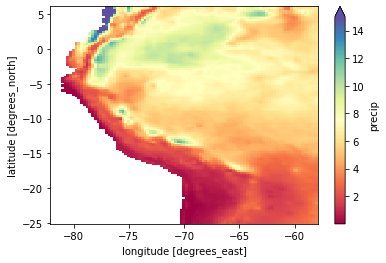

In [72]:
ch_on_era['precip'].mean('time').plot(vmax=15, cmap='Spectral')

/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


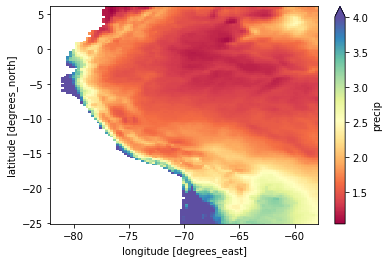

In [71]:
(ch_on_era['precip'].std('time')/ch_on_era['precip'].mean('time')).plot(vmax=4, cmap='Spectral')

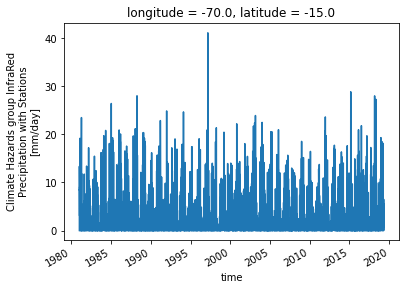

In [33]:
ch_on_era['precip'].sel(longitude=-70, latitude=-15, method='nearest').plot()

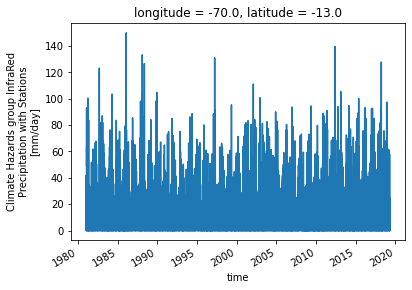

In [35]:
ch_on_era['precip'].sel(longitude=-70, latitude=-13, method='nearest').plot()

In [61]:
a = np.arange(100)*0
b = np.arange(100)*0

In [62]:
mask = [0,10,50,70, 20,80]
a[mask] = 150

In [63]:
mask = [0,10,15,20,25,30,35, 40,45, 50,55, 60,65, 70, 80, 90, 95]
mask2 = [3,33,43,54,66,77,88,99]
b[mask] = 80
b[mask2] = 120

In [65]:
print(np.mean(a), np.mean(b))
print(np.std(a-np.mean(a)), np.std(b-np.mean(b)))

9.0 23.2
35.62302626111375 41.25239386993196


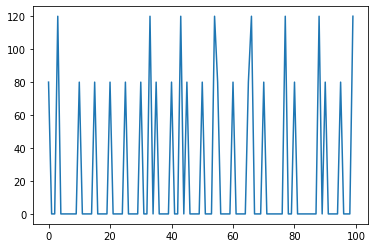

In [68]:
plt.plot(b)

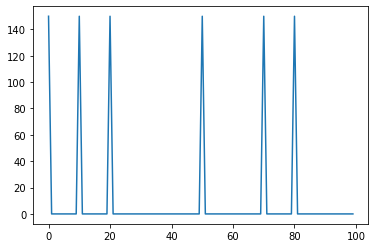

In [69]:
plt.plot(a)

In [79]:
g_doypick = g_on_era['tir'].sel(time=((g_on_era['time.year']>=1985)&(g_on_era['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-65))

In [80]:
chirps_bimod = chirps_doypick.rolling(time=60, min_periods=3, center=True).mean(dim='time').where((chirps_doypick['time.month']<=7)|(chirps_doypick['time.month']>=8))

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Reductions will be applied along the rolling dimension '['time']'. Passing the 'dim' kwarg to reduction operations has no effect and will raise an error in xarray 0.16.0.
  """Entry point for launching an IPython kernel.


In [85]:
ch_doy=chirps_bimod.groupby('time.dayofyear').mean('time')

In [ ]:
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(-81,-65), lat=slice(-25,0))
topo_on_g = corr_all.salem.lookup_transform(topo)

In [96]:
ch_doy_lonmean = ch_doy.where(topo_on_g>=2000).mean('longitude')/ch_doy.where(topo_on_g>=2000).mean('longitude').sum('dayofyear')#.argmax('latitude')

In [100]:
maxpos = ch_doy_lonmean.argmax('latitude')

In [97]:
ch_doy_lonmean.sel(latitude=-9.5).sum().values

/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(1.0000001, dtype=float32)

In [54]:
ts = ch_doy.sel(longitude=-77.25, latitude=-9.5).values

/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [83]:
import scipy.signal as signal
def loc_minmax(array):
    
    outarr_max = np.zeros((array.shape[1], array.shape[2]))

    for x in range(array.shape[2]):
        for y in range(array.shape[1]):
            
            ts = array.values[:,y,x]
            
            #tsmooth = smooth(ts,window_len=30,window='hanning')
            
            #out = signal.argrelextrema(tsmooth, np.greater,order=3)
            
            out = np.where(ts == ndimage.maximum_filter(ts, (20,), mode='constant', cval=np.amax(ts) + 1))
            
            outarr_max[y,x] = out[0].size
    da = xr.DataArray(out_arr, coords=[array['latitude'], array['longitude']], dims=['latitude','longitude'])
    return da
    

In [84]:
maxs = loc_minmax(ch_doy)

/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/m

/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/m

/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/m

/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/m

/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/m

/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/m

KeyboardInterrupt: 

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


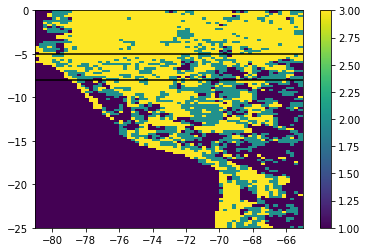

In [71]:
plt.pcolormesh(ch_doy.longitude,ch_doy.latitude, maxs, vmin=1, vmax=3)
plt.axhline(-8, color='k')
plt.axhline(-5, color='k')
plt.colorbar()

/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


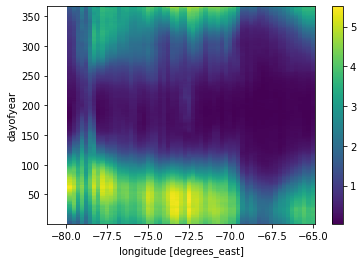

In [75]:
ch_doy.where(topo_on_g>2000).median('latitude').plot()

In [73]:
## places

south_amaz = [-72.6, -71.6,-9,-8]
north_amaz = [-71, -70, -12,-11]
fname = '/home/ck/DIR/cornkle/data/HUARAZ/shapes/riosan_sel_one.shp'
sdf = salem.read_shapefile(fname)
sdf = salem.transform_geopandas(sdf, to_crs=salem.wgs84)

hua_box = [-78.5, -76.5, -11, -8]
alti_box = [-72.6, -71.6, -15,-14]

In [17]:
corr_all = corr_all.assign_coords(dayofyear=corr_all.dayofyear.values)
corr_first = corr_first.assign_coords(dayofyear=corr_first.dayofyear.values)
corr_end = corr_end.assign_coords(dayofyear=corr_end.dayofyear.values)

In [18]:
corr_all = corr_all.sel(latitude=slice(-25,0), longitude=slice(-81,-65))
corr_first = corr_first.sel(latitude=slice(-25,0), longitude=slice(-81,-65))
corr_end = corr_end.sel(latitude=slice(-25,0), longitude=slice(-81,-65))

In [20]:
corr_first_num = corr_first['r'].where(corr_first['pval']<=0.05).count('dayofyear')

In [21]:
corr_end_num = corr_end['r'].where(corr_end['pval']<=0.05).count('dayofyear')


In [24]:
def find_doy(corr_all, gt_doy=None, lt_doy=None):
    
    if gt_doy is not None:
        mask = corr_all.dayofyear>gt_doy
        pindex = 0
        rcheck = -60  #-60
    if lt_doy is not None:
        mask = corr_all.dayofyear<lt_doy
        pindex = -1
        rcheck = 60 #60
        
    corr = corr_all.sel(dayofyear=mask)
    corr_sig = corr.where(corr['pval']<=0.05)
   
    array = corr_sig['r'].values

    thresh = -0.1
    array[array >= thresh] = 0  # T threshold maskout
    array[np.isnan(array)] = 0  # set ocean nans to 0
    outarr_3 = np.zeros((array.shape[1], array.shape[2]))
    outarr_5 = np.zeros((array.shape[1], array.shape[2]))
    outarr_max = np.zeros((array.shape[1], array.shape[2]))

    for x in range(array.shape[2]):
        for y in range(array.shape[1]):
            
            ts = array[:,y,x]
            labels, numL = label(ts)

            u, inv = np.unique(labels, return_inverse=True)
            n = np.bincount(inv)

            inds_3 = u[(n>=3)&(u!=0)] ## min 3 days onset
            inds_5 = u[(n>=5)&(u!=0)] ## min 5 days breakdown
            

            if len(inds_3)>0:
                pos3 = np.where(labels==inds_3[pindex])
                day3 = ((corr_sig.dayofyear.values+1)[(pos3[0])[pindex]])
            else:
                day3 = np.nan

            if len(inds_5)>0:
                pos5 = np.where(labels==inds_5[pindex])
                day5 = ((corr_sig.dayofyear.values+1)[pos5[0][pindex]])
            else:
                day5 = np.nan

            if (pindex==0) & (np.sum(array[rcheck::,y,x]==0)/abs(rcheck)>0.75):  # remove pixels where more than 40 days in Nov/Dev have no correlation
                day3 = np.nan
                day5 = np.nan
            if (pindex==-1) & (np.sum(array[::rcheck,y,x]==0)/abs(rcheck)>0.75): # remove pixels where more than 40 days in Jan/Feb have no correlation
                day3 = np.nan
                day5 = np.nan

            outarr_3[y,x] = day3
            outarr_5[y,x] = day5
            outarr_max[y,x] = (corr_sig.dayofyear.values+1)[np.argmax(ts)]
            
    outarr_3 = xr.DataArray(outarr_3, coords=[corr['latitude'], corr['longitude']], dims=['latitude','longitude'])
    outarr_5 = xr.DataArray(outarr_5, coords=[corr['latitude'], corr['longitude']], dims=[ 'latitude','longitude'])
            
#     grid = corr.salem.grid.regrid(factor=1)
#     #ipdb.set_trace()
#     outarr_3 = grid.lookup_transform(outarr_3)
#     outarr_5 = grid.lookup_transform(outarr_5)
#     grid = grid.to_dataset()
#     outarr_3 = xr.DataArray(outarr_3, coords=[grid['y'], grid['x']], dims=['latitude','longitude'])
#     outarr_5 = xr.DataArray(outarr_5, coords=[grid['y'], grid['x']], dims=['latitude','longitude'])

    return outarr_3, outarr_5

In [378]:
def dry_wet_chirps(chirps, doy_start, doy_end, dry=False, wet=False):
    
    pindex = 0
    
    tot =(365-doy_start)+doy_end
        
    ts_rainy = chirps#.where((chirps['time.dayofyear']>=doy_start) | (chirps['time.dayofyear']<=doy_end) &(np.isfinite(tot)))
    
    if wet:
        #in_arr = (ts_rainy>=8)
        in_arr = (ts_rainy<=-4000)
        in_arr.values = (in_arr.values.astype(int))
        tag = 'wet'
    if dry:
        #in_arr = (ts_rainy<=4)
        in_arr = ts_rainy>-4000
        in_arr.values = (in_arr.values.astype(int))
        tag = 'dry'
    
    out_arr = np.zeros((ts_rainy.shape[0],ts_rainy.shape[1], ts_rainy.shape[2]))

    for x in range(ts_rainy.shape[2]):
        for y in range(ts_rainy.shape[1]):
                print('Doing', x, y)
                
                dst = doy_start.isel(latitude=y, longitude=x)
                dse = doy_end.isel(latitude=y, longitude=x)
                if np.isnan(dst) | np.isnan(dse):
                    continue

                ts = in_arr.isel(latitude=y, longitude=x)

                to = tot.isel(latitude=y, longitude=x)
                ts = ts.where((ts['time.dayofyear']>=dst) | (ts['time.dayofyear']<=dse) &(np.isfinite(to)), other=0)
                #ts = ts.where((ts['time.month']>=11) | (ts['time.month']<=4) &(np.isfinite(to)), other=0)
                
                labels, numL = label(ts)

                u, inv = np.unique(labels, return_inverse=True)
                n = np.bincount(inv)

                inds_3 = u[(n>=3)&(u!=0)] ## min 3 days onset
                inds_5 = u[(n>=5)&(u!=0)] ## min 5 days breakdown
                inds_7 = u[(n>=7)&(u!=0)] ## min 5 days breakdown


                if len(inds_3)>0:
                    for i in inds_3:
                        pos = np.where(labels==i)
                        out_arr[pos, y ,x] = 3

                if len(inds_5)>0:
                    for i in inds_5:
                        pos = np.where(labels==i)
                        out_arr[pos, y, x] = 5

                if len(inds_7)>0:
                    for i in inds_7:
                        pos = np.where(labels==i)
                        out_arr[pos, y ,x] = 7

                #ipdb.set_trace()    
    da = xr.DataArray(out_arr, coords=[ts_rainy['time'], ts_rainy['latitude'], ts_rainy['longitude']], dims=['time','latitude','longitude'])                    
        
    da.to_netcdf('/media/ck/Elements/SouthAmerica/CHIRPS/gridsat_'+tag+'_spells_8et4mm_3-7days.nc')
        

In [219]:
def dry_wet_chirps_box(chirps, doy_start, doy_end, dry=False, wet=False, box=None):
    
    pindex = 0
    
    tot =(365-doy_start)+doy_end
    
    try:
        doys = doy_start.sel(longitude=slice(box[0],box[1]), latitude=slice(box[2], box[3])).median(['latitude','longitude'])
        doye = doy_end.sel(longitude=slice(box[0],box[1]), latitude=slice(box[2], box[3])).median(['latitude','longitude'])
        chirps_box = chirps.sel(longitude=slice(box[0],box[1]), latitude=slice(box[2], box[3])).max(['latitude','longitude'])
    except:
        doys = doy_start.salem.roi(shape=sdf).median(['latitude','longitude'])
        doye = doy_end.salem.roi(shape=sdf).median(['latitude','longitude'])
        chirps_box = chirps.salem.roi(shape=sdf).max(['latitude','longitude'])
    
    #ipdb.set_trace()
    
    date = datetime.datetime(2017, 1, 1) + pd.Timedelta(str(doys.values - 1)+' days')
    dstr = date.strftime("%d/%m")
    print('Box onset', doys.values, 'Date', dstr)
    date = datetime.datetime(2017, 1, 1) + pd.Timedelta(str(doye.values - 1)+' days')
    dstr = date.strftime("%d/%m")
    print('Box retreat', doye.values, 'Date', dstr)
    #ipdb.set_trace()
    ts_rainy = chirps_box.where((chirps['time.dayofyear']>=doys) | (chirps['time.dayofyear']<=doye))
    
    #ch_perc = ts_rainy.groupby('time.year').quantile(0.99)
    
    if wet:
        in_arr = (ts_rainy>=8)
        in_arr.values = (in_arr.values.astype(int))
        tag = 'wet'
    if dry:
        in_arr = (ts_rainy<=4)
        in_arr.values = (in_arr.values.astype(int))
        tag = 'dry'
    
    out_arr = np.zeros(ts_rainy.shape[0])


    if (np.isnan(doys) | np.isnan(doye)):
        ipdb.set_trace()

    ts = in_arr

    labels, numL = label(ts)

    u, inv = np.unique(labels, return_inverse=True)
    n = np.bincount(inv)

    inds_3 = u[(n>=3)&(u!=0)] ## min 3 days onset
    inds_5 = u[(n>=5)&(u!=0)] ## min 5 days breakdown
    inds_7 = u[(n>=7)&(u!=0)] ## min 5 days breakdown


    if len(inds_3)>0:
        for i in inds_3:
            pos = np.where(labels==i)
            out_arr[pos] = 3

    if len(inds_5)>0:
        for i in inds_5:
            pos = np.where(labels==i)
            out_arr[pos] = 5

    if len(inds_7)>0:
        for i in inds_7:
            pos = np.where(labels==i)
            out_arr[pos] = 7


    da = xr.DataArray(out_arr, coords=[ts_rainy['time']], dims=['time'])                    

#da.to_netcdf('/media/ck/Elements/SouthAmerica/CHIRPS/'+tag+'_spells_1mm_3-9days.nc')
    return da, ts_rainy, in_arr

In [161]:
outarr_3, outarr_5 = find_doy(corr_all, gt_doy=213)  # doy 213 is 1st August
endarr_3, endarr_5= find_doy(corr_all, lt_doy=182) # doy 182 is 1st July

In [162]:
outarr_3f, outarr_5f = find_doy(corr_first, gt_doy=213)  # doy 213 is 1st August
endarr_3f, endarr_5f= find_doy(corr_first, lt_doy=182) # doy 182 is 1st July

In [34]:
outarr_3e, outarr_5e = find_doy(corr_end, gt_doy=213)  # doy 213 is 1st August
endarr_3e, endarr_5e= find_doy(corr_end, lt_doy=182) # doy 182 is 1st July

In [266]:
test = ((365-outarr_3e)+endarr_5e)-((365-outarr_3f)+endarr_5f)

In [268]:
chirps_doypick.shape

(12418, 125, 97)

In [269]:
outarr_3.shape

(101, 65)

In [379]:
dry_wet_chirps(g_doypick, outarr_3, endarr_5, dry=True, wet=False)

Doing 0 0
Doing 0 1
Doing 0 2
Doing 0 3
Doing 0 4
Doing 0 5
Doing 0 6
Doing 0 7
Doing 0 8
Doing 0 9
Doing 0 10
Doing 0 11
Doing 0 12
Doing 0 13
Doing 0 14
Doing 0 15
Doing 0 16
Doing 0 17
Doing 0 18
Doing 0 19
Doing 0 20
Doing 0 21
Doing 0 22
Doing 0 23
Doing 0 24
Doing 0 25
Doing 0 26
Doing 0 27
Doing 0 28
Doing 0 29
Doing 0 30
Doing 0 31
Doing 0 32
Doing 0 33
Doing 0 34
Doing 0 35
Doing 0 36
Doing 0 37
Doing 0 38
Doing 0 39
Doing 0 40
Doing 0 41
Doing 0 42
Doing 0 43
Doing 0 44
Doing 0 45
Doing 0 46
Doing 0 47
Doing 0 48
Doing 0 49
Doing 0 50
Doing 0 51
Doing 0 52
Doing 0 53
Doing 0 54
Doing 0 55
Doing 0 56
Doing 0 57
Doing 0 58
Doing 0 59
Doing 0 60
Doing 0 61
Doing 0 62
Doing 0 63
Doing 0 64
Doing 0 65
Doing 0 66
Doing 0 67
Doing 0 68
Doing 0 69
Doing 0 70
Doing 0 71
Doing 0 72
Doing 0 73
Doing 0 74
Doing 0 75
Doing 0 76
Doing 0 77
Doing 0 78
Doing 0 79
Doing 0 80
Doing 0 81
Doing 0 82
Doing 0 83
Doing 0 84
Doing 0 85
Doing 0 86
Doing 0 87
Doing 0 88
Doing 0 89
Doing 0 90
Doing 0 9

Doing 7 78
Doing 7 79
Doing 7 80
Doing 7 81
Doing 7 82
Doing 7 83
Doing 7 84
Doing 7 85
Doing 7 86
Doing 7 87
Doing 7 88
Doing 7 89
Doing 7 90
Doing 7 91
Doing 7 92
Doing 7 93
Doing 7 94
Doing 7 95
Doing 7 96
Doing 7 97
Doing 7 98
Doing 7 99
Doing 7 100
Doing 8 0
Doing 8 1
Doing 8 2
Doing 8 3
Doing 8 4
Doing 8 5
Doing 8 6
Doing 8 7
Doing 8 8
Doing 8 9
Doing 8 10
Doing 8 11
Doing 8 12
Doing 8 13
Doing 8 14
Doing 8 15
Doing 8 16
Doing 8 17
Doing 8 18
Doing 8 19
Doing 8 20
Doing 8 21
Doing 8 22
Doing 8 23
Doing 8 24
Doing 8 25
Doing 8 26
Doing 8 27
Doing 8 28
Doing 8 29
Doing 8 30
Doing 8 31
Doing 8 32
Doing 8 33
Doing 8 34
Doing 8 35
Doing 8 36
Doing 8 37
Doing 8 38
Doing 8 39
Doing 8 40
Doing 8 41
Doing 8 42
Doing 8 43
Doing 8 44
Doing 8 45
Doing 8 46
Doing 8 47
Doing 8 48
Doing 8 49
Doing 8 50
Doing 8 51
Doing 8 52
Doing 8 53
Doing 8 54
Doing 8 55
Doing 8 56
Doing 8 57
Doing 8 58
Doing 8 59
Doing 8 60
Doing 8 61
Doing 8 62
Doing 8 63
Doing 8 64
Doing 8 65
Doing 8 66
Doing 8 67
Doing 8 

Doing 14 80
Doing 14 81
Doing 14 82
Doing 14 83
Doing 14 84
Doing 14 85
Doing 14 86
Doing 14 87
Doing 14 88
Doing 14 89
Doing 14 90
Doing 14 91
Doing 14 92
Doing 14 93
Doing 14 94
Doing 14 95
Doing 14 96
Doing 14 97
Doing 14 98
Doing 14 99
Doing 14 100
Doing 15 0
Doing 15 1
Doing 15 2
Doing 15 3
Doing 15 4
Doing 15 5
Doing 15 6
Doing 15 7
Doing 15 8
Doing 15 9
Doing 15 10
Doing 15 11
Doing 15 12
Doing 15 13
Doing 15 14
Doing 15 15
Doing 15 16
Doing 15 17
Doing 15 18
Doing 15 19
Doing 15 20
Doing 15 21
Doing 15 22
Doing 15 23
Doing 15 24
Doing 15 25
Doing 15 26
Doing 15 27
Doing 15 28
Doing 15 29
Doing 15 30
Doing 15 31
Doing 15 32
Doing 15 33
Doing 15 34
Doing 15 35
Doing 15 36
Doing 15 37
Doing 15 38
Doing 15 39
Doing 15 40
Doing 15 41
Doing 15 42
Doing 15 43
Doing 15 44
Doing 15 45
Doing 15 46
Doing 15 47
Doing 15 48
Doing 15 49
Doing 15 50
Doing 15 51
Doing 15 52
Doing 15 53
Doing 15 54
Doing 15 55
Doing 15 56
Doing 15 57
Doing 15 58
Doing 15 59
Doing 15 60
Doing 15 61
Doing 15 62
D

Doing 22 45
Doing 22 46
Doing 22 47
Doing 22 48
Doing 22 49
Doing 22 50
Doing 22 51
Doing 22 52
Doing 22 53
Doing 22 54
Doing 22 55
Doing 22 56
Doing 22 57
Doing 22 58
Doing 22 59
Doing 22 60
Doing 22 61
Doing 22 62
Doing 22 63
Doing 22 64
Doing 22 65
Doing 22 66
Doing 22 67
Doing 22 68
Doing 22 69
Doing 22 70
Doing 22 71
Doing 22 72
Doing 22 73
Doing 22 74
Doing 22 75
Doing 22 76
Doing 22 77
Doing 22 78
Doing 22 79
Doing 22 80
Doing 22 81
Doing 22 82
Doing 22 83
Doing 22 84
Doing 22 85
Doing 22 86
Doing 22 87
Doing 22 88
Doing 22 89
Doing 22 90
Doing 22 91
Doing 22 92
Doing 22 93
Doing 22 94
Doing 22 95
Doing 22 96
Doing 22 97
Doing 22 98
Doing 22 99
Doing 22 100
Doing 23 0
Doing 23 1
Doing 23 2
Doing 23 3
Doing 23 4
Doing 23 5
Doing 23 6
Doing 23 7
Doing 23 8
Doing 23 9
Doing 23 10
Doing 23 11
Doing 23 12
Doing 23 13
Doing 23 14
Doing 23 15
Doing 23 16
Doing 23 17
Doing 23 18
Doing 23 19
Doing 23 20
Doing 23 21
Doing 23 22
Doing 23 23
Doing 23 24
Doing 23 25
Doing 23 26
Doing 23 27
D

Doing 29 51
Doing 29 52
Doing 29 53
Doing 29 54
Doing 29 55
Doing 29 56
Doing 29 57
Doing 29 58
Doing 29 59
Doing 29 60
Doing 29 61
Doing 29 62
Doing 29 63
Doing 29 64
Doing 29 65
Doing 29 66
Doing 29 67
Doing 29 68
Doing 29 69
Doing 29 70
Doing 29 71
Doing 29 72
Doing 29 73
Doing 29 74
Doing 29 75
Doing 29 76
Doing 29 77
Doing 29 78
Doing 29 79
Doing 29 80
Doing 29 81
Doing 29 82
Doing 29 83
Doing 29 84
Doing 29 85
Doing 29 86
Doing 29 87
Doing 29 88
Doing 29 89
Doing 29 90
Doing 29 91
Doing 29 92
Doing 29 93
Doing 29 94
Doing 29 95
Doing 29 96
Doing 29 97
Doing 29 98
Doing 29 99
Doing 29 100
Doing 30 0
Doing 30 1
Doing 30 2
Doing 30 3
Doing 30 4
Doing 30 5
Doing 30 6
Doing 30 7
Doing 30 8
Doing 30 9
Doing 30 10
Doing 30 11
Doing 30 12
Doing 30 13
Doing 30 14
Doing 30 15
Doing 30 16
Doing 30 17
Doing 30 18
Doing 30 19
Doing 30 20
Doing 30 21
Doing 30 22
Doing 30 23
Doing 30 24
Doing 30 25
Doing 30 26
Doing 30 27
Doing 30 28
Doing 30 29
Doing 30 30
Doing 30 31
Doing 30 32
Doing 30 33
D

Doing 36 37
Doing 36 38
Doing 36 39
Doing 36 40
Doing 36 41
Doing 36 42
Doing 36 43
Doing 36 44
Doing 36 45
Doing 36 46
Doing 36 47
Doing 36 48
Doing 36 49
Doing 36 50
Doing 36 51
Doing 36 52
Doing 36 53
Doing 36 54
Doing 36 55
Doing 36 56
Doing 36 57
Doing 36 58
Doing 36 59
Doing 36 60
Doing 36 61
Doing 36 62
Doing 36 63
Doing 36 64
Doing 36 65
Doing 36 66
Doing 36 67
Doing 36 68
Doing 36 69
Doing 36 70
Doing 36 71
Doing 36 72
Doing 36 73
Doing 36 74
Doing 36 75
Doing 36 76
Doing 36 77
Doing 36 78
Doing 36 79
Doing 36 80
Doing 36 81
Doing 36 82
Doing 36 83
Doing 36 84
Doing 36 85
Doing 36 86
Doing 36 87
Doing 36 88
Doing 36 89
Doing 36 90
Doing 36 91
Doing 36 92
Doing 36 93
Doing 36 94
Doing 36 95
Doing 36 96
Doing 36 97
Doing 36 98
Doing 36 99
Doing 36 100
Doing 37 0
Doing 37 1
Doing 37 2
Doing 37 3
Doing 37 4
Doing 37 5
Doing 37 6
Doing 37 7
Doing 37 8
Doing 37 9
Doing 37 10
Doing 37 11
Doing 37 12
Doing 37 13
Doing 37 14
Doing 37 15
Doing 37 16
Doing 37 17
Doing 37 18
Doing 37 19
D

Doing 43 30
Doing 43 31
Doing 43 32
Doing 43 33
Doing 43 34
Doing 43 35
Doing 43 36
Doing 43 37
Doing 43 38
Doing 43 39
Doing 43 40
Doing 43 41
Doing 43 42
Doing 43 43
Doing 43 44
Doing 43 45
Doing 43 46
Doing 43 47
Doing 43 48
Doing 43 49
Doing 43 50
Doing 43 51
Doing 43 52
Doing 43 53
Doing 43 54
Doing 43 55
Doing 43 56
Doing 43 57
Doing 43 58
Doing 43 59
Doing 43 60
Doing 43 61
Doing 43 62
Doing 43 63
Doing 43 64
Doing 43 65
Doing 43 66
Doing 43 67
Doing 43 68
Doing 43 69
Doing 43 70
Doing 43 71
Doing 43 72
Doing 43 73
Doing 43 74
Doing 43 75
Doing 43 76
Doing 43 77
Doing 43 78
Doing 43 79
Doing 43 80
Doing 43 81
Doing 43 82
Doing 43 83
Doing 43 84
Doing 43 85
Doing 43 86
Doing 43 87
Doing 43 88
Doing 43 89
Doing 43 90
Doing 43 91
Doing 43 92
Doing 43 93
Doing 43 94
Doing 43 95
Doing 43 96
Doing 43 97
Doing 43 98
Doing 43 99
Doing 43 100
Doing 44 0
Doing 44 1
Doing 44 2
Doing 44 3
Doing 44 4
Doing 44 5
Doing 44 6
Doing 44 7
Doing 44 8
Doing 44 9
Doing 44 10
Doing 44 11
Doing 44 12
D

Doing 50 15
Doing 50 16
Doing 50 17
Doing 50 18
Doing 50 19
Doing 50 20
Doing 50 21
Doing 50 22
Doing 50 23
Doing 50 24
Doing 50 25
Doing 50 26
Doing 50 27
Doing 50 28
Doing 50 29
Doing 50 30
Doing 50 31
Doing 50 32
Doing 50 33
Doing 50 34
Doing 50 35
Doing 50 36
Doing 50 37
Doing 50 38
Doing 50 39
Doing 50 40
Doing 50 41
Doing 50 42
Doing 50 43
Doing 50 44
Doing 50 45
Doing 50 46
Doing 50 47
Doing 50 48
Doing 50 49
Doing 50 50
Doing 50 51
Doing 50 52
Doing 50 53
Doing 50 54
Doing 50 55
Doing 50 56
Doing 50 57
Doing 50 58
Doing 50 59
Doing 50 60
Doing 50 61
Doing 50 62
Doing 50 63
Doing 50 64
Doing 50 65
Doing 50 66
Doing 50 67
Doing 50 68
Doing 50 69
Doing 50 70
Doing 50 71
Doing 50 72
Doing 50 73
Doing 50 74
Doing 50 75
Doing 50 76
Doing 50 77
Doing 50 78
Doing 50 79
Doing 50 80
Doing 50 81
Doing 50 82
Doing 50 83
Doing 50 84
Doing 50 85
Doing 50 86
Doing 50 87
Doing 50 88
Doing 50 89
Doing 50 90
Doing 50 91
Doing 50 92
Doing 50 93
Doing 50 94
Doing 50 95
Doing 50 96
Doing 50 97
Doin

Doing 57 4
Doing 57 5
Doing 57 6
Doing 57 7
Doing 57 8
Doing 57 9
Doing 57 10
Doing 57 11
Doing 57 12
Doing 57 13
Doing 57 14
Doing 57 15
Doing 57 16
Doing 57 17
Doing 57 18
Doing 57 19
Doing 57 20
Doing 57 21
Doing 57 22
Doing 57 23
Doing 57 24
Doing 57 25
Doing 57 26
Doing 57 27
Doing 57 28
Doing 57 29
Doing 57 30
Doing 57 31
Doing 57 32
Doing 57 33
Doing 57 34
Doing 57 35
Doing 57 36
Doing 57 37
Doing 57 38
Doing 57 39
Doing 57 40
Doing 57 41
Doing 57 42
Doing 57 43
Doing 57 44
Doing 57 45
Doing 57 46
Doing 57 47
Doing 57 48
Doing 57 49
Doing 57 50
Doing 57 51
Doing 57 52
Doing 57 53
Doing 57 54
Doing 57 55
Doing 57 56
Doing 57 57
Doing 57 58
Doing 57 59
Doing 57 60
Doing 57 61
Doing 57 62
Doing 57 63
Doing 57 64
Doing 57 65
Doing 57 66
Doing 57 67
Doing 57 68
Doing 57 69
Doing 57 70
Doing 57 71
Doing 57 72
Doing 57 73
Doing 57 74
Doing 57 75
Doing 57 76
Doing 57 77
Doing 57 78
Doing 57 79
Doing 57 80
Doing 57 81
Doing 57 82
Doing 57 83
Doing 57 84
Doing 57 85
Doing 57 86
Doing 57 8

Doing 64 6
Doing 64 7
Doing 64 8
Doing 64 9
Doing 64 10
Doing 64 11
Doing 64 12
Doing 64 13
Doing 64 14
Doing 64 15
Doing 64 16
Doing 64 17
Doing 64 18
Doing 64 19
Doing 64 20
Doing 64 21
Doing 64 22
Doing 64 23
Doing 64 24
Doing 64 25
Doing 64 26
Doing 64 27
Doing 64 28
Doing 64 29
Doing 64 30
Doing 64 31
Doing 64 32
Doing 64 33
Doing 64 34
Doing 64 35
Doing 64 36
Doing 64 37
Doing 64 38
Doing 64 39
Doing 64 40
Doing 64 41
Doing 64 42
Doing 64 43
Doing 64 44
Doing 64 45
Doing 64 46
Doing 64 47
Doing 64 48
Doing 64 49
Doing 64 50
Doing 64 51
Doing 64 52
Doing 64 53
Doing 64 54
Doing 64 55
Doing 64 56
Doing 64 57
Doing 64 58
Doing 64 59
Doing 64 60
Doing 64 61
Doing 64 62
Doing 64 63
Doing 64 64
Doing 64 65
Doing 64 66
Doing 64 67
Doing 64 68
Doing 64 69
Doing 64 70
Doing 64 71
Doing 64 72
Doing 64 73
Doing 64 74
Doing 64 75
Doing 64 76
Doing 64 77
Doing 64 78
Doing 64 79
Doing 64 80
Doing 64 81
Doing 64 82
Doing 64 83
Doing 64 84
Doing 64 85
Doing 64 86
Doing 64 87
Doing 64 88
Doing 64

In [380]:
dry_wet_chirps(g_doypick, outarr_3, endarr_5, dry=False, wet=True)

Doing 0 0
Doing 0 1
Doing 0 2
Doing 0 3
Doing 0 4
Doing 0 5
Doing 0 6
Doing 0 7
Doing 0 8
Doing 0 9
Doing 0 10
Doing 0 11
Doing 0 12
Doing 0 13
Doing 0 14
Doing 0 15
Doing 0 16
Doing 0 17
Doing 0 18
Doing 0 19
Doing 0 20
Doing 0 21
Doing 0 22
Doing 0 23
Doing 0 24
Doing 0 25
Doing 0 26
Doing 0 27
Doing 0 28
Doing 0 29
Doing 0 30
Doing 0 31
Doing 0 32
Doing 0 33
Doing 0 34
Doing 0 35
Doing 0 36
Doing 0 37
Doing 0 38
Doing 0 39
Doing 0 40
Doing 0 41
Doing 0 42
Doing 0 43
Doing 0 44
Doing 0 45
Doing 0 46
Doing 0 47
Doing 0 48
Doing 0 49
Doing 0 50
Doing 0 51
Doing 0 52
Doing 0 53
Doing 0 54
Doing 0 55
Doing 0 56
Doing 0 57
Doing 0 58
Doing 0 59
Doing 0 60
Doing 0 61
Doing 0 62
Doing 0 63
Doing 0 64
Doing 0 65
Doing 0 66
Doing 0 67
Doing 0 68
Doing 0 69
Doing 0 70
Doing 0 71
Doing 0 72
Doing 0 73
Doing 0 74
Doing 0 75
Doing 0 76
Doing 0 77
Doing 0 78
Doing 0 79
Doing 0 80
Doing 0 81
Doing 0 82
Doing 0 83
Doing 0 84
Doing 0 85
Doing 0 86
Doing 0 87
Doing 0 88
Doing 0 89
Doing 0 90
Doing 0 9

Doing 7 93
Doing 7 94
Doing 7 95
Doing 7 96
Doing 7 97
Doing 7 98
Doing 7 99
Doing 7 100
Doing 8 0
Doing 8 1
Doing 8 2
Doing 8 3
Doing 8 4
Doing 8 5
Doing 8 6
Doing 8 7
Doing 8 8
Doing 8 9
Doing 8 10
Doing 8 11
Doing 8 12
Doing 8 13
Doing 8 14
Doing 8 15
Doing 8 16
Doing 8 17
Doing 8 18
Doing 8 19
Doing 8 20
Doing 8 21
Doing 8 22
Doing 8 23
Doing 8 24
Doing 8 25
Doing 8 26
Doing 8 27
Doing 8 28
Doing 8 29
Doing 8 30
Doing 8 31
Doing 8 32
Doing 8 33
Doing 8 34
Doing 8 35
Doing 8 36
Doing 8 37
Doing 8 38
Doing 8 39
Doing 8 40
Doing 8 41
Doing 8 42
Doing 8 43
Doing 8 44
Doing 8 45
Doing 8 46
Doing 8 47
Doing 8 48
Doing 8 49
Doing 8 50
Doing 8 51
Doing 8 52
Doing 8 53
Doing 8 54
Doing 8 55
Doing 8 56
Doing 8 57
Doing 8 58
Doing 8 59
Doing 8 60
Doing 8 61
Doing 8 62
Doing 8 63
Doing 8 64
Doing 8 65
Doing 8 66
Doing 8 67
Doing 8 68
Doing 8 69
Doing 8 70
Doing 8 71
Doing 8 72
Doing 8 73
Doing 8 74
Doing 8 75
Doing 8 76
Doing 8 77
Doing 8 78
Doing 8 79
Doing 8 80
Doing 8 81
Doing 8 82
Doing 8 

Doing 15 51
Doing 15 52
Doing 15 53
Doing 15 54
Doing 15 55
Doing 15 56
Doing 15 57
Doing 15 58
Doing 15 59
Doing 15 60
Doing 15 61
Doing 15 62
Doing 15 63
Doing 15 64
Doing 15 65
Doing 15 66
Doing 15 67
Doing 15 68
Doing 15 69
Doing 15 70
Doing 15 71
Doing 15 72
Doing 15 73
Doing 15 74
Doing 15 75
Doing 15 76
Doing 15 77
Doing 15 78
Doing 15 79
Doing 15 80
Doing 15 81
Doing 15 82
Doing 15 83
Doing 15 84
Doing 15 85
Doing 15 86
Doing 15 87
Doing 15 88
Doing 15 89
Doing 15 90
Doing 15 91
Doing 15 92
Doing 15 93
Doing 15 94
Doing 15 95
Doing 15 96
Doing 15 97
Doing 15 98
Doing 15 99
Doing 15 100
Doing 16 0
Doing 16 1
Doing 16 2
Doing 16 3
Doing 16 4
Doing 16 5
Doing 16 6
Doing 16 7
Doing 16 8
Doing 16 9
Doing 16 10
Doing 16 11
Doing 16 12
Doing 16 13
Doing 16 14
Doing 16 15
Doing 16 16
Doing 16 17
Doing 16 18
Doing 16 19
Doing 16 20
Doing 16 21
Doing 16 22
Doing 16 23
Doing 16 24
Doing 16 25
Doing 16 26
Doing 16 27
Doing 16 28
Doing 16 29
Doing 16 30
Doing 16 31
Doing 16 32
Doing 16 33
D

Doing 22 58
Doing 22 59
Doing 22 60
Doing 22 61
Doing 22 62
Doing 22 63
Doing 22 64
Doing 22 65
Doing 22 66
Doing 22 67
Doing 22 68
Doing 22 69
Doing 22 70
Doing 22 71
Doing 22 72
Doing 22 73
Doing 22 74
Doing 22 75
Doing 22 76
Doing 22 77
Doing 22 78
Doing 22 79
Doing 22 80
Doing 22 81
Doing 22 82
Doing 22 83
Doing 22 84
Doing 22 85
Doing 22 86
Doing 22 87
Doing 22 88
Doing 22 89
Doing 22 90
Doing 22 91
Doing 22 92
Doing 22 93
Doing 22 94
Doing 22 95
Doing 22 96
Doing 22 97
Doing 22 98
Doing 22 99
Doing 22 100
Doing 23 0
Doing 23 1
Doing 23 2
Doing 23 3
Doing 23 4
Doing 23 5
Doing 23 6
Doing 23 7
Doing 23 8
Doing 23 9
Doing 23 10
Doing 23 11
Doing 23 12
Doing 23 13
Doing 23 14
Doing 23 15
Doing 23 16
Doing 23 17
Doing 23 18
Doing 23 19
Doing 23 20
Doing 23 21
Doing 23 22
Doing 23 23
Doing 23 24
Doing 23 25
Doing 23 26
Doing 23 27
Doing 23 28
Doing 23 29
Doing 23 30
Doing 23 31
Doing 23 32
Doing 23 33
Doing 23 34
Doing 23 35
Doing 23 36
Doing 23 37
Doing 23 38
Doing 23 39
Doing 23 40
D

Doing 29 49
Doing 29 50
Doing 29 51
Doing 29 52
Doing 29 53
Doing 29 54
Doing 29 55
Doing 29 56
Doing 29 57
Doing 29 58
Doing 29 59
Doing 29 60
Doing 29 61
Doing 29 62
Doing 29 63
Doing 29 64
Doing 29 65
Doing 29 66
Doing 29 67
Doing 29 68
Doing 29 69
Doing 29 70
Doing 29 71
Doing 29 72
Doing 29 73
Doing 29 74
Doing 29 75
Doing 29 76
Doing 29 77
Doing 29 78
Doing 29 79
Doing 29 80
Doing 29 81
Doing 29 82
Doing 29 83
Doing 29 84
Doing 29 85
Doing 29 86
Doing 29 87
Doing 29 88
Doing 29 89
Doing 29 90
Doing 29 91
Doing 29 92
Doing 29 93
Doing 29 94
Doing 29 95
Doing 29 96
Doing 29 97
Doing 29 98
Doing 29 99
Doing 29 100
Doing 30 0
Doing 30 1
Doing 30 2
Doing 30 3
Doing 30 4
Doing 30 5
Doing 30 6
Doing 30 7
Doing 30 8
Doing 30 9
Doing 30 10
Doing 30 11
Doing 30 12
Doing 30 13
Doing 30 14
Doing 30 15
Doing 30 16
Doing 30 17
Doing 30 18
Doing 30 19
Doing 30 20
Doing 30 21
Doing 30 22
Doing 30 23
Doing 30 24
Doing 30 25
Doing 30 26
Doing 30 27
Doing 30 28
Doing 30 29
Doing 30 30
Doing 30 31
D

Doing 36 50
Doing 36 51
Doing 36 52
Doing 36 53
Doing 36 54
Doing 36 55
Doing 36 56
Doing 36 57
Doing 36 58
Doing 36 59
Doing 36 60
Doing 36 61
Doing 36 62
Doing 36 63
Doing 36 64
Doing 36 65
Doing 36 66
Doing 36 67
Doing 36 68
Doing 36 69
Doing 36 70
Doing 36 71
Doing 36 72
Doing 36 73
Doing 36 74
Doing 36 75
Doing 36 76
Doing 36 77
Doing 36 78
Doing 36 79
Doing 36 80
Doing 36 81
Doing 36 82
Doing 36 83
Doing 36 84
Doing 36 85
Doing 36 86
Doing 36 87
Doing 36 88
Doing 36 89
Doing 36 90
Doing 36 91
Doing 36 92
Doing 36 93
Doing 36 94
Doing 36 95
Doing 36 96
Doing 36 97
Doing 36 98
Doing 36 99
Doing 36 100
Doing 37 0
Doing 37 1
Doing 37 2
Doing 37 3
Doing 37 4
Doing 37 5
Doing 37 6
Doing 37 7
Doing 37 8
Doing 37 9
Doing 37 10
Doing 37 11
Doing 37 12
Doing 37 13
Doing 37 14
Doing 37 15
Doing 37 16
Doing 37 17
Doing 37 18
Doing 37 19
Doing 37 20
Doing 37 21
Doing 37 22
Doing 37 23
Doing 37 24
Doing 37 25
Doing 37 26
Doing 37 27
Doing 37 28
Doing 37 29
Doing 37 30
Doing 37 31
Doing 37 32
D

Doing 43 33
Doing 43 34
Doing 43 35
Doing 43 36
Doing 43 37
Doing 43 38
Doing 43 39
Doing 43 40
Doing 43 41
Doing 43 42
Doing 43 43
Doing 43 44
Doing 43 45
Doing 43 46
Doing 43 47
Doing 43 48
Doing 43 49
Doing 43 50
Doing 43 51
Doing 43 52
Doing 43 53
Doing 43 54
Doing 43 55
Doing 43 56
Doing 43 57
Doing 43 58
Doing 43 59
Doing 43 60
Doing 43 61
Doing 43 62
Doing 43 63
Doing 43 64
Doing 43 65
Doing 43 66
Doing 43 67
Doing 43 68
Doing 43 69
Doing 43 70
Doing 43 71
Doing 43 72
Doing 43 73
Doing 43 74
Doing 43 75
Doing 43 76
Doing 43 77
Doing 43 78
Doing 43 79
Doing 43 80
Doing 43 81
Doing 43 82
Doing 43 83
Doing 43 84
Doing 43 85
Doing 43 86
Doing 43 87
Doing 43 88
Doing 43 89
Doing 43 90
Doing 43 91
Doing 43 92
Doing 43 93
Doing 43 94
Doing 43 95
Doing 43 96
Doing 43 97
Doing 43 98
Doing 43 99
Doing 43 100
Doing 44 0
Doing 44 1
Doing 44 2
Doing 44 3
Doing 44 4
Doing 44 5
Doing 44 6
Doing 44 7
Doing 44 8
Doing 44 9
Doing 44 10
Doing 44 11
Doing 44 12
Doing 44 13
Doing 44 14
Doing 44 15
D

Doing 50 32
Doing 50 33
Doing 50 34
Doing 50 35
Doing 50 36
Doing 50 37
Doing 50 38
Doing 50 39
Doing 50 40
Doing 50 41
Doing 50 42
Doing 50 43
Doing 50 44
Doing 50 45
Doing 50 46
Doing 50 47
Doing 50 48
Doing 50 49
Doing 50 50
Doing 50 51
Doing 50 52
Doing 50 53
Doing 50 54
Doing 50 55
Doing 50 56
Doing 50 57
Doing 50 58
Doing 50 59
Doing 50 60
Doing 50 61
Doing 50 62
Doing 50 63
Doing 50 64
Doing 50 65
Doing 50 66
Doing 50 67
Doing 50 68
Doing 50 69
Doing 50 70
Doing 50 71
Doing 50 72
Doing 50 73
Doing 50 74
Doing 50 75
Doing 50 76
Doing 50 77
Doing 50 78
Doing 50 79
Doing 50 80
Doing 50 81
Doing 50 82
Doing 50 83
Doing 50 84
Doing 50 85
Doing 50 86
Doing 50 87
Doing 50 88
Doing 50 89
Doing 50 90
Doing 50 91
Doing 50 92
Doing 50 93
Doing 50 94
Doing 50 95
Doing 50 96
Doing 50 97
Doing 50 98
Doing 50 99
Doing 50 100
Doing 51 0
Doing 51 1
Doing 51 2
Doing 51 3
Doing 51 4
Doing 51 5
Doing 51 6
Doing 51 7
Doing 51 8
Doing 51 9
Doing 51 10
Doing 51 11
Doing 51 12
Doing 51 13
Doing 51 14
D

Doing 57 24
Doing 57 25
Doing 57 26
Doing 57 27
Doing 57 28
Doing 57 29
Doing 57 30
Doing 57 31
Doing 57 32
Doing 57 33
Doing 57 34
Doing 57 35
Doing 57 36
Doing 57 37
Doing 57 38
Doing 57 39
Doing 57 40
Doing 57 41
Doing 57 42
Doing 57 43
Doing 57 44
Doing 57 45
Doing 57 46
Doing 57 47
Doing 57 48
Doing 57 49
Doing 57 50
Doing 57 51
Doing 57 52
Doing 57 53
Doing 57 54
Doing 57 55
Doing 57 56
Doing 57 57
Doing 57 58
Doing 57 59
Doing 57 60
Doing 57 61
Doing 57 62
Doing 57 63
Doing 57 64
Doing 57 65
Doing 57 66
Doing 57 67
Doing 57 68
Doing 57 69
Doing 57 70
Doing 57 71
Doing 57 72
Doing 57 73
Doing 57 74
Doing 57 75
Doing 57 76
Doing 57 77
Doing 57 78
Doing 57 79
Doing 57 80
Doing 57 81
Doing 57 82
Doing 57 83
Doing 57 84
Doing 57 85
Doing 57 86
Doing 57 87
Doing 57 88
Doing 57 89
Doing 57 90
Doing 57 91
Doing 57 92
Doing 57 93
Doing 57 94
Doing 57 95
Doing 57 96
Doing 57 97
Doing 57 98
Doing 57 99
Doing 57 100
Doing 58 0
Doing 58 1
Doing 58 2
Doing 58 3
Doing 58 4
Doing 58 5
Doing 58 

Doing 64 19
Doing 64 20
Doing 64 21
Doing 64 22
Doing 64 23
Doing 64 24
Doing 64 25
Doing 64 26
Doing 64 27
Doing 64 28
Doing 64 29
Doing 64 30
Doing 64 31
Doing 64 32
Doing 64 33
Doing 64 34
Doing 64 35
Doing 64 36
Doing 64 37
Doing 64 38
Doing 64 39
Doing 64 40
Doing 64 41
Doing 64 42
Doing 64 43
Doing 64 44
Doing 64 45
Doing 64 46
Doing 64 47
Doing 64 48
Doing 64 49
Doing 64 50
Doing 64 51
Doing 64 52
Doing 64 53
Doing 64 54
Doing 64 55
Doing 64 56
Doing 64 57
Doing 64 58
Doing 64 59
Doing 64 60
Doing 64 61
Doing 64 62
Doing 64 63
Doing 64 64
Doing 64 65
Doing 64 66
Doing 64 67
Doing 64 68
Doing 64 69
Doing 64 70
Doing 64 71
Doing 64 72
Doing 64 73
Doing 64 74
Doing 64 75
Doing 64 76
Doing 64 77
Doing 64 78
Doing 64 79
Doing 64 80
Doing 64 81
Doing 64 82
Doing 64 83
Doing 64 84
Doing 64 85
Doing 64 86
Doing 64 87
Doing 64 88
Doing 64 89
Doing 64 90
Doing 64 91
Doing 64 92
Doing 64 93
Doing 64 94
Doing 64 95
Doing 64 96
Doing 64 97
Doing 64 98
Doing 64 99
Doing 64 100


In [473]:
wet_test = xr.open_dataarray('/media/ck/Elements/SouthAmerica/CHIRPS/wet_spells_8et4mm_3-7days.nc')

In [474]:
dry_test = xr.open_dataarray('/media/ck/Elements/SouthAmerica/CHIRPS/dry_spells_8et4mm_3-7days.nc')

In [415]:
ndvi = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/NDVI/onERA/*.nc').sel(latitude=slice(-25,0), longitude=slice(-81,-65)).load()

In [515]:
ndvi_month = ndvi.isel(time=(ndvi['time.month']>=11)|(ndvi['time.month']<=3)).where(topo_on_g>2000)
#.salem.roi(shape=sdf).mean(['latitude','longitude']

In [516]:
ndvi_month['precip']

<xarray.DataArray 'precip' (time: 107, latitude: 101, longitude: 65)>
array([[[     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ..., 0.673192,      nan,
              nan],
        ...,
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan]],

       [[     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ..., 0.677092,      nan,
              nan],
...
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan]],

       [[     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ..., 0.733008,      nan,
              nan],
        ...,
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan]]])
Coordinates:
  * time       (time) datetime64[ns] 2000-02-01 2000-03-01 ... 2021-03-01
  * longitude  (longitude) float32 -81.0 -80.75 -80.5 ... -65.5 -65.25 -65.0
  * latitude   (latitude) float32 -25.0 -24.75 -24.5 -24.25 ... -0.5 -0.25 0.0
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

In [517]:
ndvi_month = ndvi_month.groupby(ndvi_month['time.year']).mean('time').sel(longitude=slice(alti_box[0],alti_box[1]), latitude=slice(alti_box[2], alti_box[3])).mean(['latitude', 'longitude'])

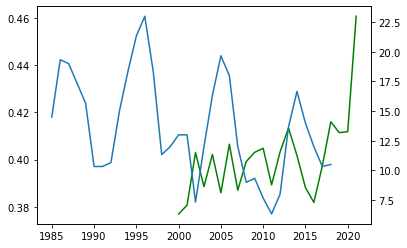

In [505]:
f = plt.figure()
ax = f.add_subplot(111)
ax.plot(ndvi_month.year, ndvi_month['precip'], color='g')
ax1 = ax.twinx()
ax1.plot(hyear.year, hyear)

In [503]:
pos = np.intersect1d(ndvi_month.year, hyear.year)
stats.linregress(ndvi_month['precip'].sel(year=pos), hyear.sel(year=pos))

LinregressResult(slope=-46.190680051818944, intercept=30.346114214610907, rvalue=-0.13772940082196664, pvalue=0.5739235092275612, stderr=80.56464859380876)

In [494]:
hyear = hua_dry.where(hua_dry==3).groupby(hua_dry['time.year']).count().rolling(year=3, min_periods=2, center=True).mean(dim='year')

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Reductions will be applied along the rolling dimension '['year']'. Passing the 'dim' kwarg to reduction operations has no effect and will raise an error in xarray 0.16.0.
  """Entry point for launching an IPython kernel.


In [495]:
hyear

<xarray.DataArray (year: 34)>
array([14.5       , 19.33333333, 19.        , 17.33333333, 15.66666667,
       10.33333333, 10.33333333, 10.66666667, 15.        , 18.33333333,
       21.33333333, 23.        , 18.33333333, 11.33333333, 12.        ,
       13.        , 13.        ,  7.33333333, 12.        , 16.33333333,
       19.66666667, 18.        , 12.        ,  9.        ,  9.33333333,
        7.66666667,  6.33333333,  8.        , 13.66666667, 16.66666667,
       14.        , 12.        , 10.33333333, 10.5       ])
Coordinates:
  * year     (year) int64 1985 1986 1987 1988 1989 ... 2014 2015 2016 2017 2018

In [383]:
def calc_trend(mean_years, method='polyfit', sig=False, wilks=False):
    # stack lat and lon into a single dimension called allpoints
    datastacked = mean_years.stack(allpoints=['latitude', 'longitude'])


    # apply the function over allpoints to calculate the trend at each point
    print('Entering trend calc')

    alpha = 0.05
    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='mk':
        dtrend = datastacked.groupby('allpoints').apply(uda.linear_trend_mk, alpha=alpha, eps=0.01,nb_valid=10)
        dtrend = dtrend.unstack('allpoints')
        if sig:
            (dtrend['slope'].values)[dtrend['ind'].values==0] = 0

    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='polyfit':
        dtrend = datastacked.groupby('allpoints').apply(uda.linear_trend_lingress,nb_valid=10)
        dtrend = dtrend.unstack('allpoints')

        if sig:
            (dtrend['slope'].values)[dtrend['pval'].values > alpha] = 0

    ddtrend = dtrend['slope']

    if wilks and sig:
        try:
            pthresh = us.fdr_threshold(dtrend['pval'].values[np.isfinite(dtrend['pval'].values)], alpha=alpha)
            ddtrend.values[(dtrend['pval'].values > pthresh) | np.isnan(dtrend['pval'].values)] = np.nan
        except ValueError:
            ddtrend.values = ddtrend.values * np.nan
            pthresh = np.nan
        print('p value threshold', pthresh)
    #ipdb.set_trace()
    # unstack back to lat lon coordinates
    return ddtrend

In [408]:
wet_yearly3 = (wet_test.where(wet_test==3).groupby(wet_test['time.year']).count())/3#/3).mean('year')
wet_yearly5 = (wet_test.where(wet_test==5).groupby(wet_test['time.year']).count())/5#/5).mean('year')
wet_yearly7 = (wet_test.where(wet_test==7).groupby(wet_test['time.year']).count())/7#/7).mean('year')

In [409]:
dry_yearly3 = dry_test.where(dry_test==3).groupby(dry_test['time.year']).count()/3#.mean('year')/3
dry_yearly5 = dry_test.where(dry_test==5).groupby(dry_test['time.year']).count()/5#.mean('year')/5
dry_yearly7 = dry_test.where(dry_test==7).groupby(dry_test['time.year']).count()/7#.mean('year')/7

In [386]:
wet_max = wet_yearly3.copy(deep=True)
wet_max.values[wet_yearly3>0] = 3
wet_max.values[wet_yearly5>wet_yearly3] = 5
wet_max.values[wet_yearly7>wet_yearly5] = 7

In [387]:
dry_max = dry_yearly3.copy(deep=True)
dry_max.values[dry_yearly3>0] = 3
dry_max.values[dry_yearly5>dry_yearly3] = 5
dry_max.values[dry_yearly7>dry_yearly5] = 7

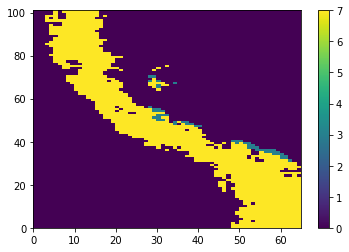

In [388]:
plt.pcolormesh(dry_max)
plt.colorbar()

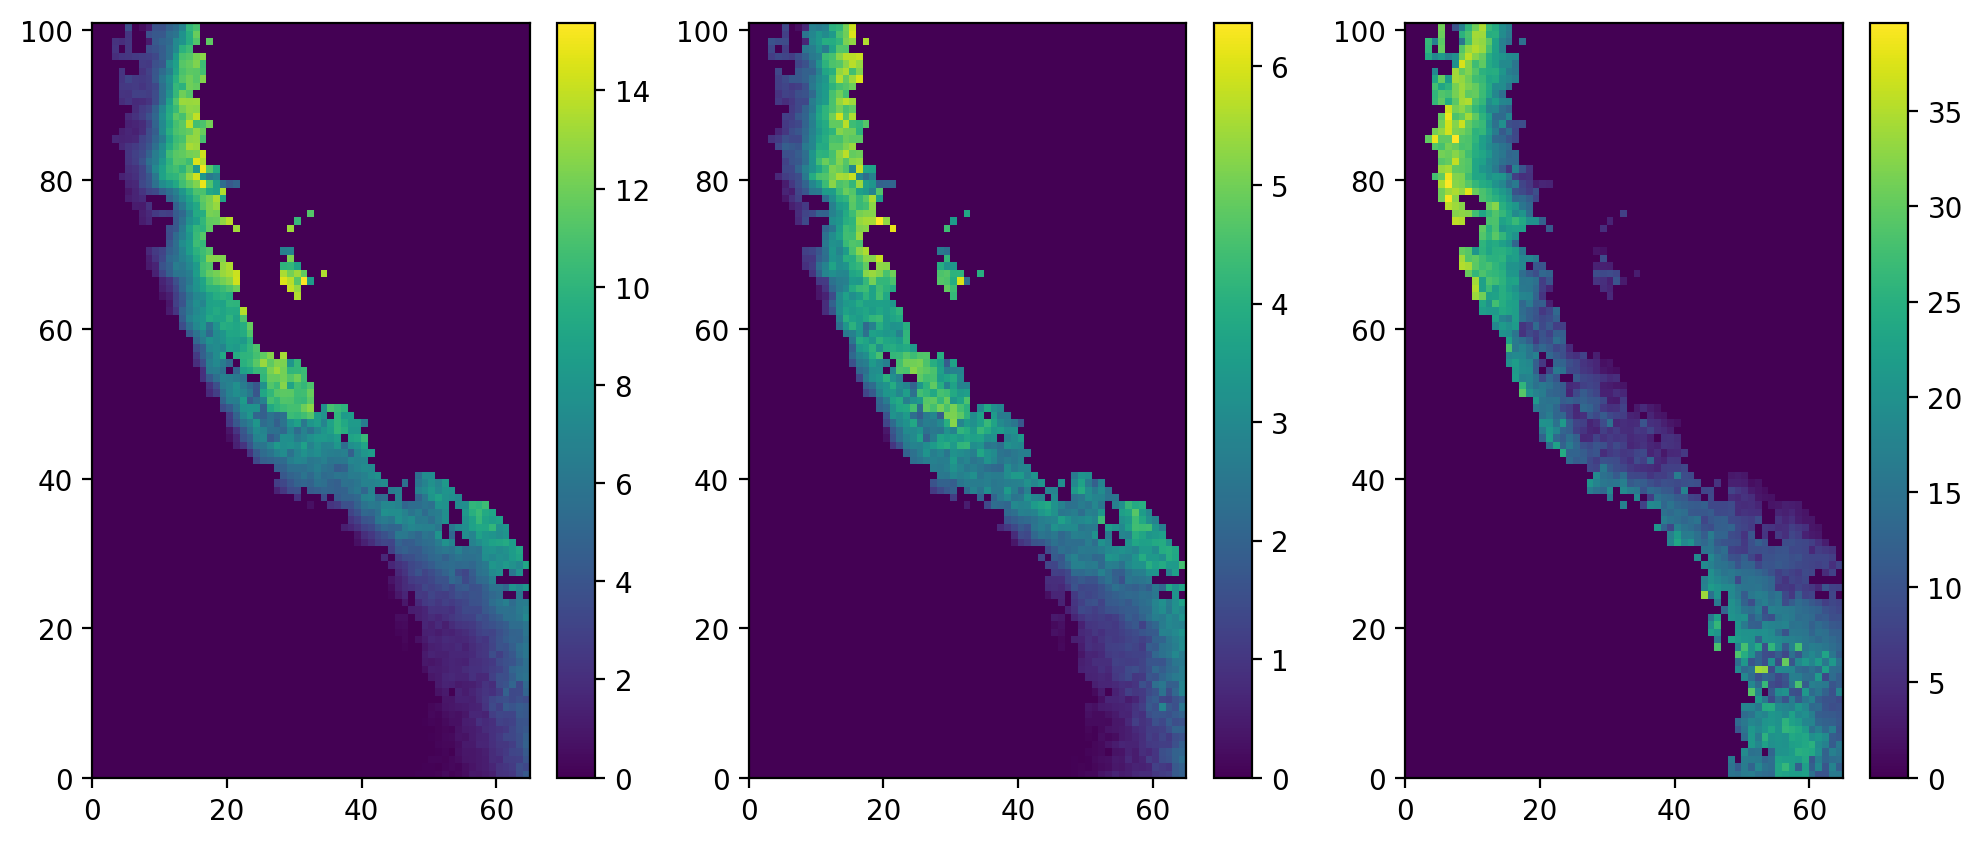

In [389]:
f = plt.figure(figsize=(12,5), dpi=200)
ax = f.add_subplot(131)
plt.pcolormesh(dry_yearly3)
plt.colorbar()

ax = f.add_subplot(132)
plt.pcolormesh(dry_yearly5)
plt.colorbar()

ax = f.add_subplot(133)
plt.pcolormesh(dry_yearly7)
plt.colorbar()

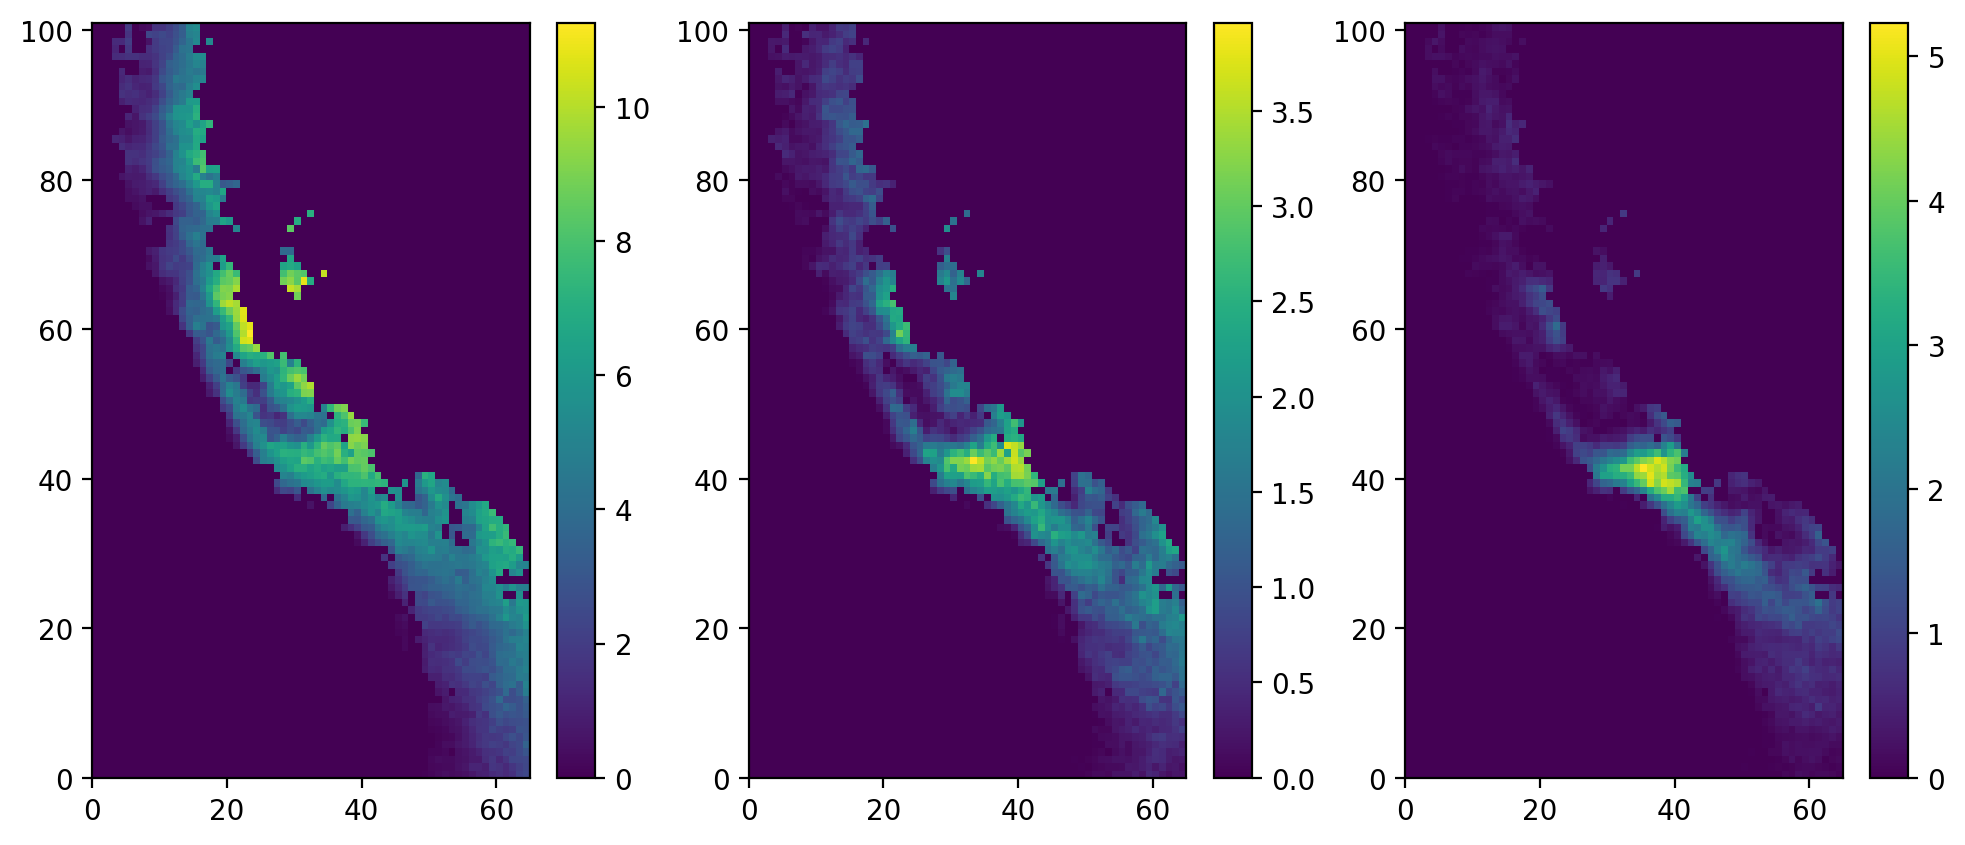

In [390]:
f = plt.figure(figsize=(12,5), dpi=200)
ax = f.add_subplot(131)
plt.pcolormesh(wet_yearly3)
plt.colorbar()

ax = f.add_subplot(132)
plt.pcolormesh(wet_yearly5)
plt.colorbar()

ax = f.add_subplot(133)
plt.pcolormesh(wet_yearly7)
plt.colorbar()

In [410]:
test_trend3 = calc_trend(wet_yearly3, sig=True)
test_trend5 = calc_trend(wet_yearly5, sig=True)
test_trend7 = calc_trend(wet_yearly7, sig=True)

Entering trend calc
Entering trend calc
Entering trend calc


In [411]:
dry_trend3 = calc_trend(dry_yearly3, sig=True)
dry_trend5 = calc_trend(dry_yearly5, sig=True)
dry_trend7 = calc_trend(dry_yearly7, sig=True)

Entering trend calc
Entering trend calc
Entering trend calc


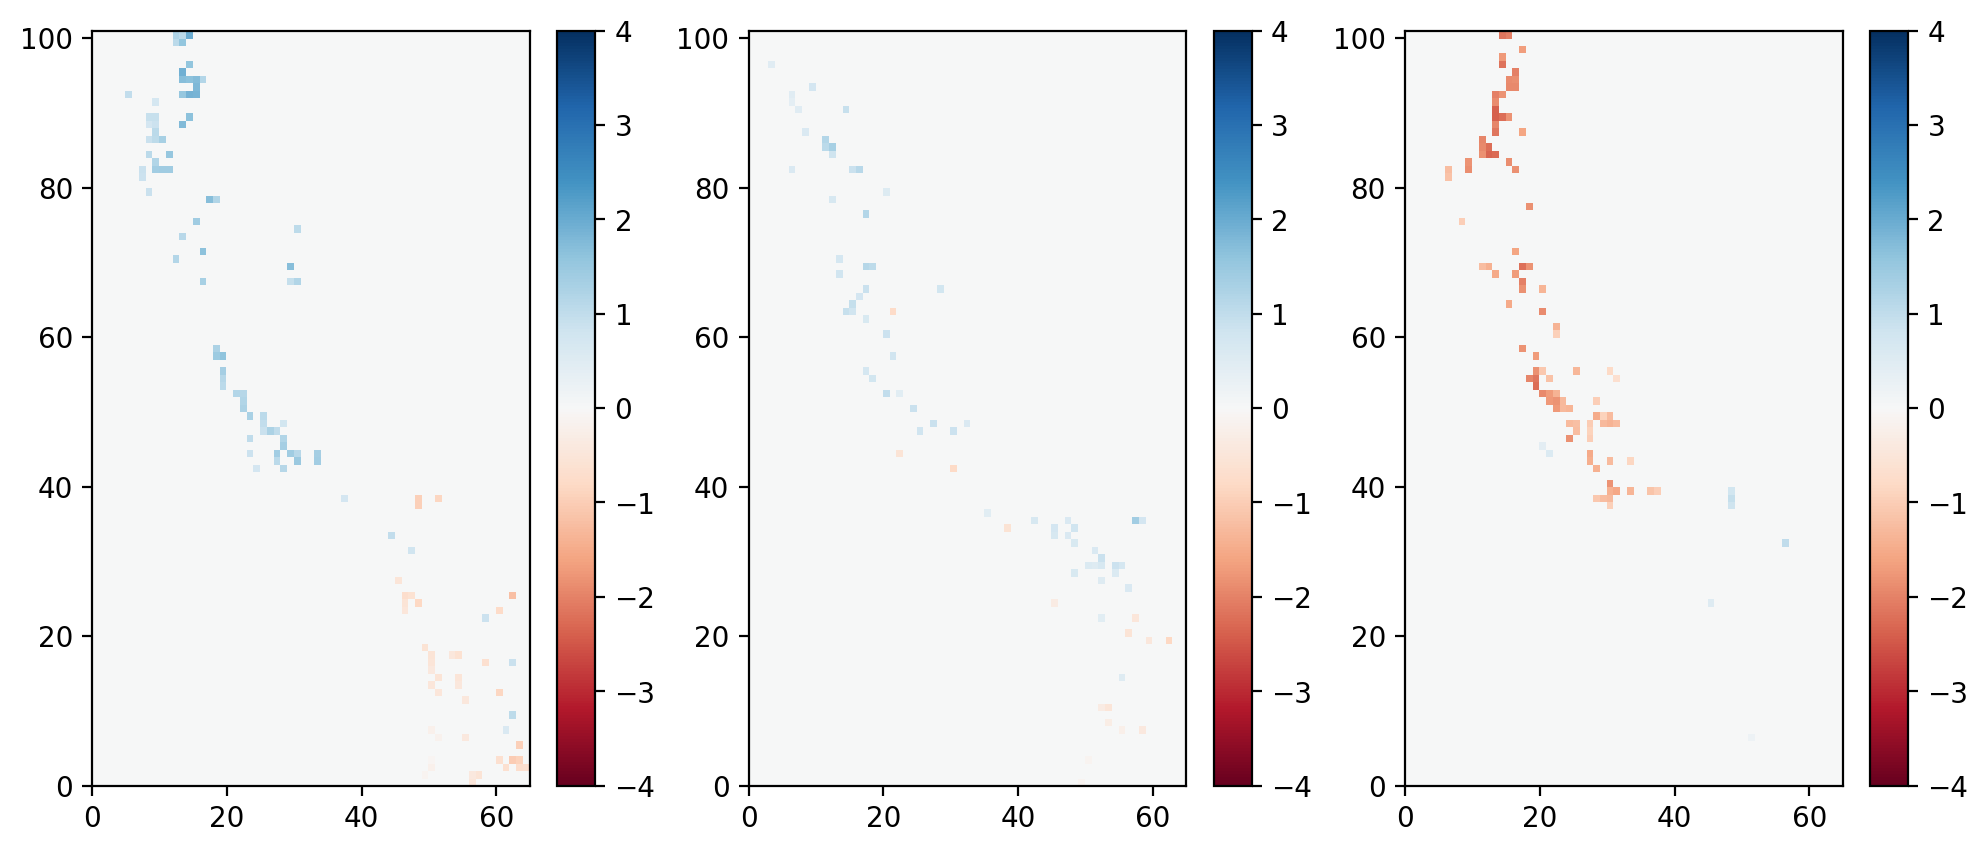

In [412]:
f = plt.figure(figsize=(12,5), dpi=200)
ax = f.add_subplot(131)
plt.pcolormesh(dry_trend3*10, vmin=-4, vmax=4, cmap='RdBu')
plt.colorbar()

ax = f.add_subplot(132)
plt.pcolormesh(dry_trend5*10, vmin=-4, vmax=4, cmap='RdBu')
plt.colorbar()

ax = f.add_subplot(133)
plt.pcolormesh(dry_trend7*10, vmin=-4, vmax=4, cmap='RdBu')
plt.colorbar()

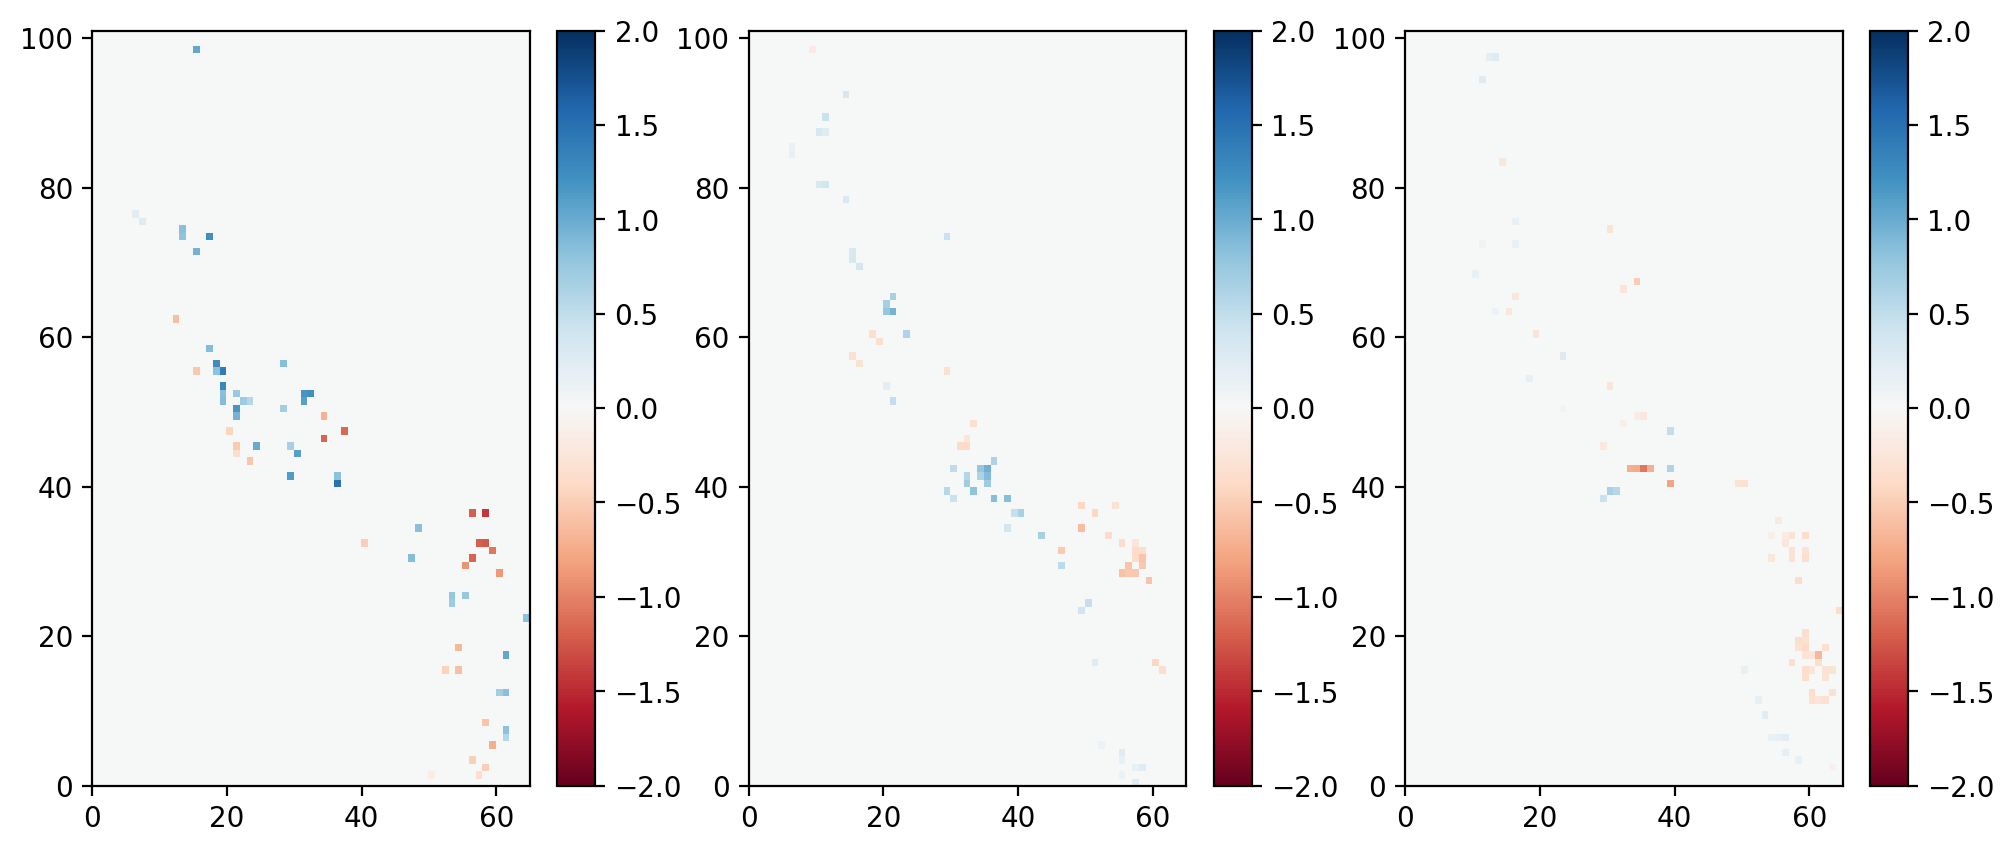

In [414]:
f = plt.figure(figsize=(12,5), dpi=200)
ax = f.add_subplot(131)
plt.pcolormesh(test_trend3*10, vmin=-2, vmax=2, cmap='RdBu')
plt.colorbar()

ax = f.add_subplot(132)
plt.pcolormesh(test_trend5*10, vmin=-2, vmax=2, cmap='RdBu')
plt.colorbar()

ax = f.add_subplot(133)
plt.pcolormesh(test_trend7*10, vmin=-2, vmax=2, cmap='RdBu')
plt.colorbar()

In [479]:
hua_wet, all_wet, filtered = dry_wet_chirps_box(chirps_doypick, outarr_3, endarr_5, wet=True, box=alti_box)

Box onset 276.5 Date 03/10
Box retreat 103.0 Date 13/04


In [480]:
hua_dry, all_dry, filtered_dry = dry_wet_chirps_box(chirps_doypick, outarr_3, endarr_5, dry=True, box=alti_box)

Box onset 276.5 Date 03/10
Box retreat 103.0 Date 13/04


In [192]:
emean = era.sel(longitude=slice(hua_box[0],hua_box[1]), latitude=slice(hua_box[2], hua_box[3])).mean(['latitude', 'longitude'])

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Reductions will be applied along the rolling dimension '['year']'. Passing the 'dim' kwarg to reduction operations has no effect and will raise an error in xarray 0.16.0.
  """Entry point for launching an IPython kernel.


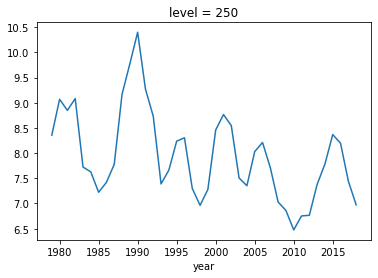

In [212]:
emean['u'].where((emean['time.month']>=9)).groupby(emean['time.year']).std().rolling(year=3, min_periods=2, center=True).mean(dim='year').plot()

In [ ]:

corr_sig = corr_all.where(corr_all['pval']<=0.05)
# mask = corr_sig.dayofyear>213
# corr = corr_sig.sel(dayofyear=mask)

array = corr_sig['r']
thresh = -0.1
array = array.where(array<thresh, other=0)  # T threshold maskout

In [ ]:
array.sel(longitude=-77.25, latitude=-9.5).plot()

In [ ]:
np.sum(array.sel(longitude=-77.25, latitude=-9.5).values[-75::]<-0.1)/ 75   #x = 15 , y=62

In [ ]:
ts = array.sel(longitude=-77.25, latitude=-9.5).values
labels, numL = label((ts == 0).astype(int))#label(ts)

In [402]:
def find_doy_max(corr_all, start, end, gt_doy=None, lt_doy=None):

    if gt_doy is not None:
        mask = corr_all.dayofyear>gt_doy
        pindex = 0
        rcheck = -60
    if lt_doy is not None:
        mask = corr_all.dayofyear<lt_doy
        pindex = -1
        rcheck = 60
        
    corr = corr_all#.sel(dayofyear=mask)
    corr_sig = corr.where(corr['pval']<=0.05)
   
    array = corr_sig['r']

    thresh = -0.1
    array = array.where(array<thresh, other=0) # T threshold maskout # set ocean nans to 0
    
    outarr_max = np.zeros((array.shape[1], array.shape[2]))*np.nan
    corr_max = np.zeros((array.shape[1], array.shape[2]))*np.nan
    

    for x in range(array.shape[2]):
        for y in range(array.shape[1]):
            #ipdb.set_trace()
            ts = array.isel(longitude=x, latitude=y)
            starts = start.values[y,x]
            ends = end.values[y,x]
            
            if np.isnan(starts) | np.isnan(ends):
                continue
            
            #ipdb.set_trace()
            valmax = ts.isel(dayofyear=((ts.dayofyear>starts) | (ts.dayofyear<ends))).argmax()
            #ipdb.set_trace()
            doys = (ts.isel(dayofyear=((ts.dayofyear>starts) | (ts.dayofyear<ends))).dayofyear.values+1)[valmax]
            month = datetime.datetime(2017, 1, 1) + pd.Timedelta(str(doys - 1)+' days')
            outarr_max[y,x] = month.month
            corr_max[y,x] = ts.isel(dayofyear=((ts.dayofyear>starts) | (ts.dayofyear<ends)))[valmax]
            
    out_max = xr.DataArray(outarr_max, coords=[corr['latitude'], corr['longitude']], dims=['latitude','longitude'])
    corr_out_max = xr.DataArray(corr_max, coords=[corr['latitude'], corr['longitude']], dims=['latitude','longitude'])

    return out_max, corr_out_max

In [403]:
outmax_gt, corrmax = find_doy_max(corr_all, outarr_3, endarr_5, gt_doy=213)

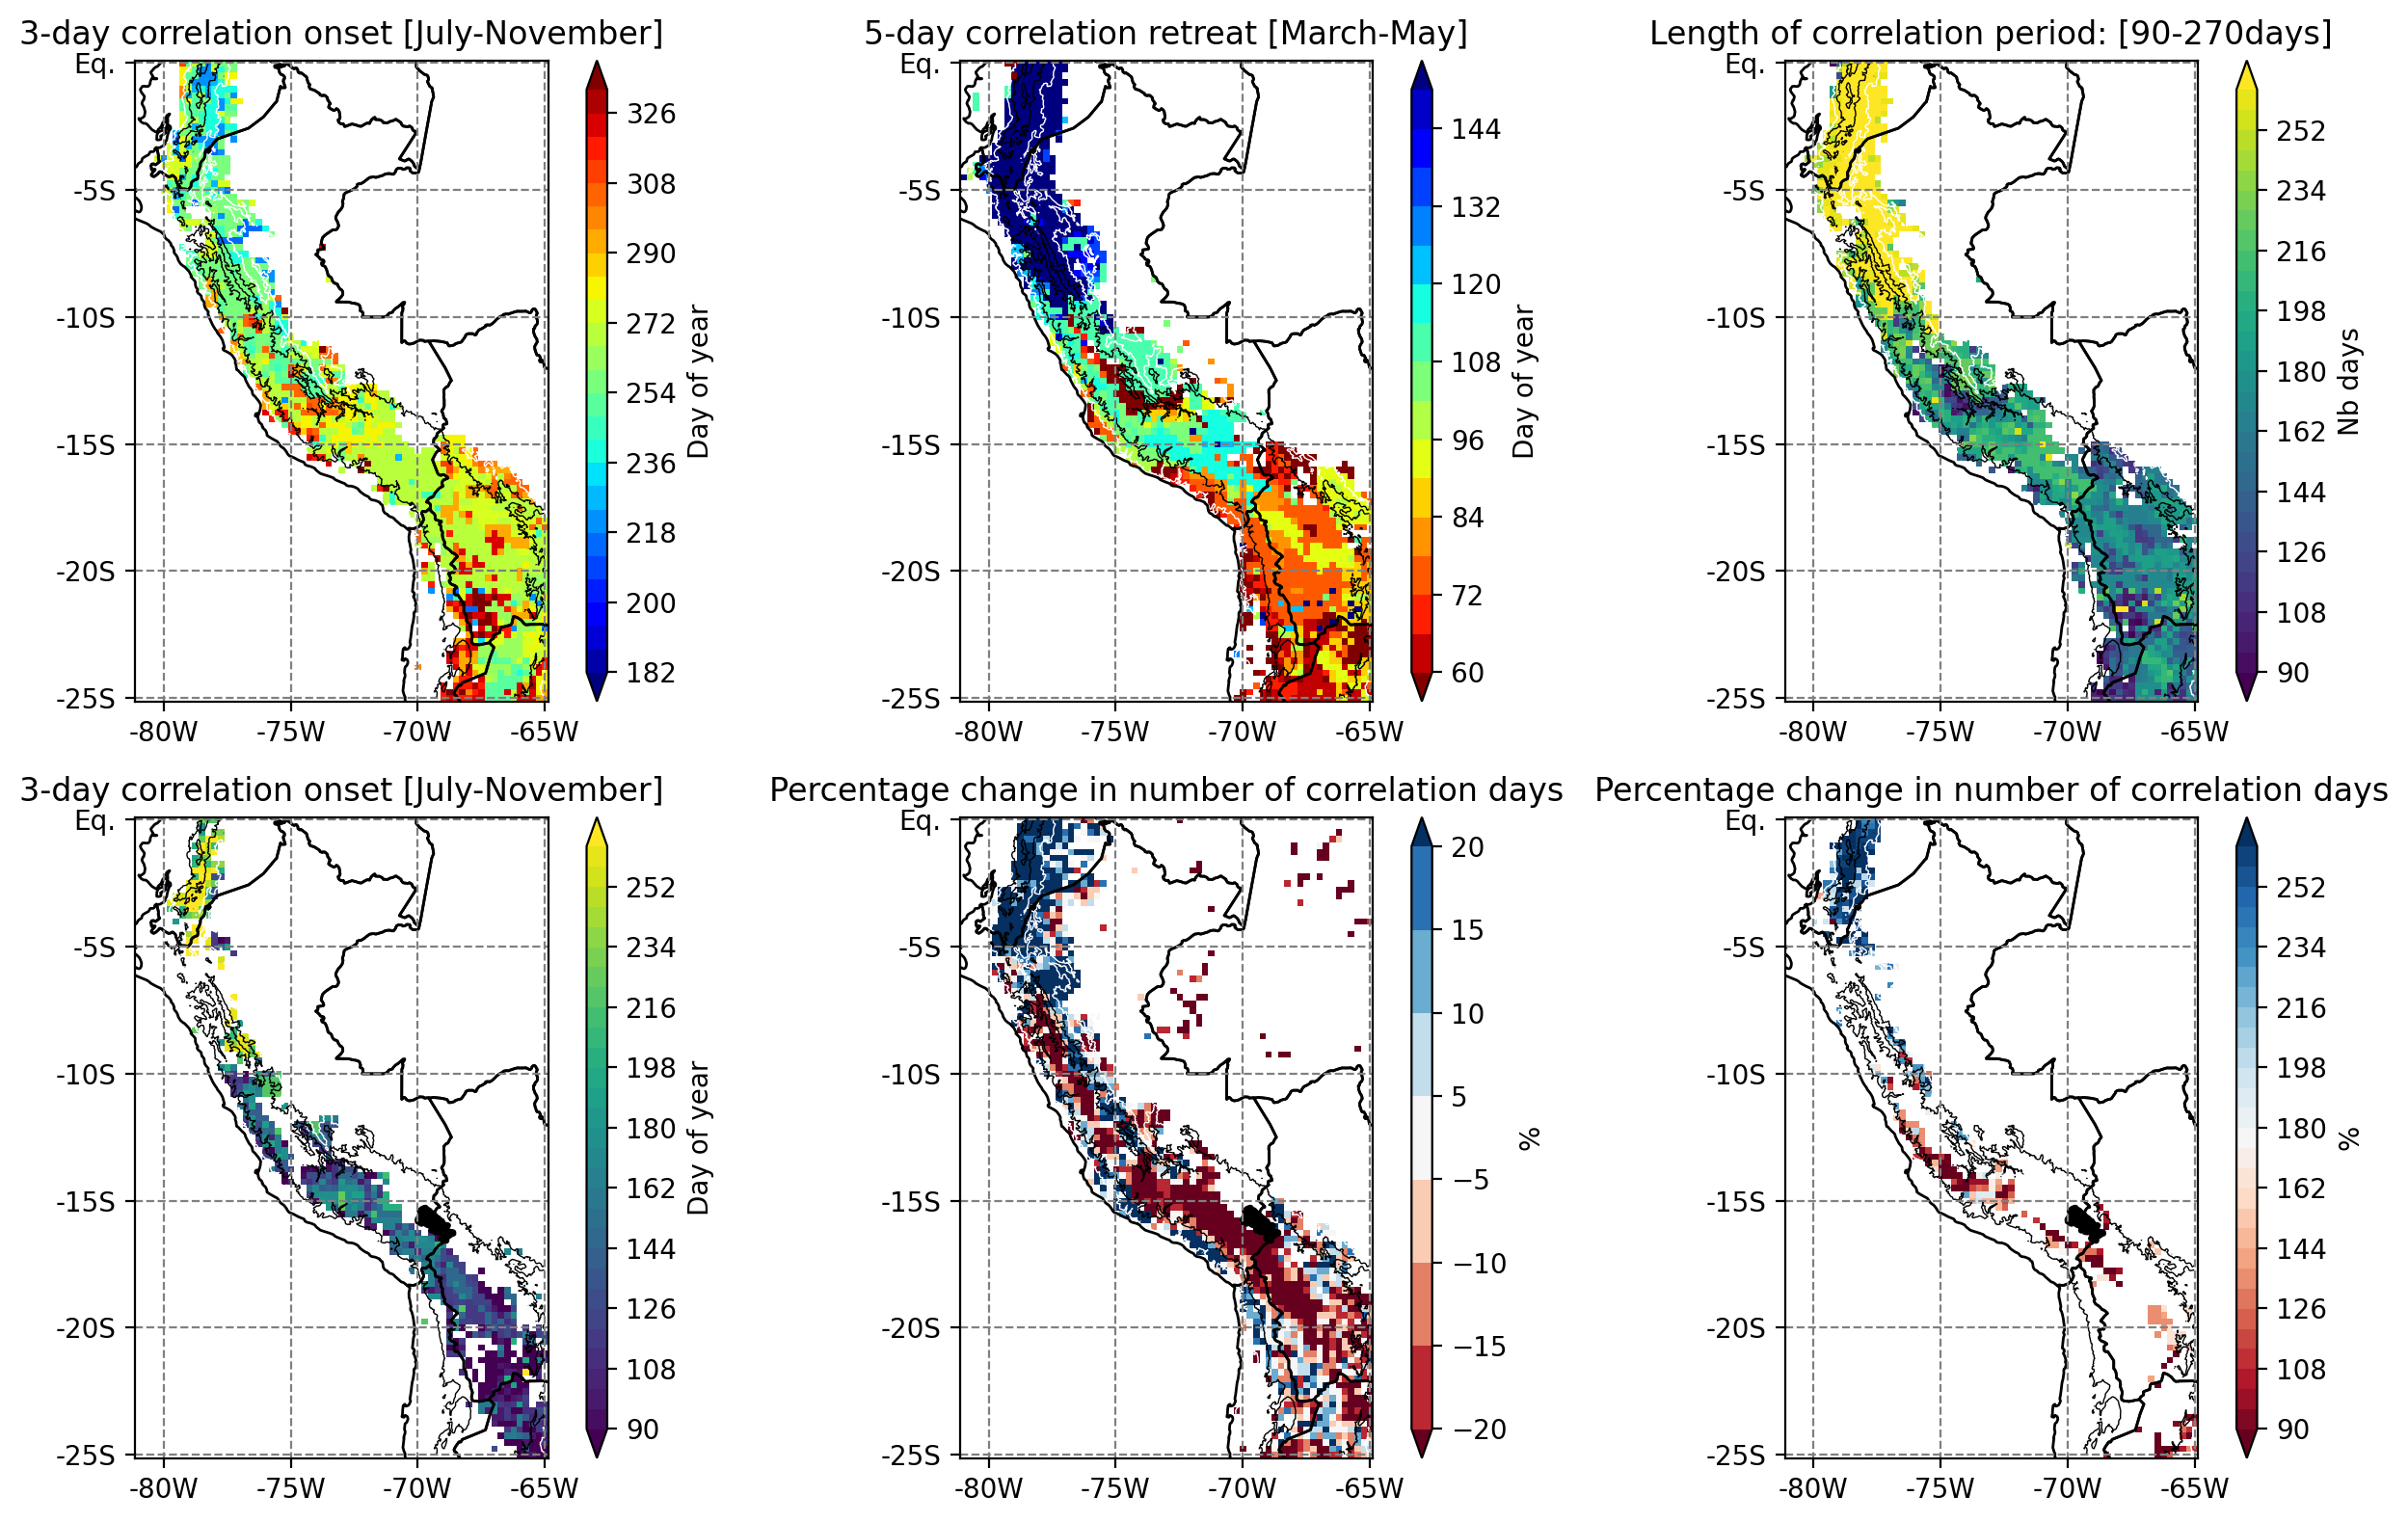

In [398]:
lakes = salem.read_shapefile(salem.get_demo_file('ne_50m_lakes.shp'),
                              cached=True)

map = corr_all.salem.get_map()
f = plt.figure(figsize=(13,8), dpi=200)

ax = f.add_subplot(231)
outarr_3.values[(topo_on_g<300)]=np.nan
map.set_data(outarr_3)
map.set_plot_params(levels=np.arange(182,335,6), cmap='jet', extend='both') #[182,213,244,274,305,335, 366]  # 182-July, 335- December
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys', linewidths=0.5)
plt.plot(-77.5, -9.5, 'ro', markersize=5)
map.visualize(cbar_title='Day of year', title='3-day correlation onset [July-November]')

ax = f.add_subplot(232)
endarr_5.values[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(endarr_5)
map.set_plot_params(levels=np.arange(60,152,6), cmap='jet_r', extend='both') # 60 March, 152 June
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys', linewidths=0.5)
map.visualize(cbar_title='Day of year', title='5-day correlation retreat [March-May]')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(233)
endarr_5.values[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data((365-outarr_3)+endarr_5)
map.set_plot_params(levels=np.arange(90,270,6), cmap='viridis', extend='both')
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys', linewidths=0.5)
map.visualize(cbar_title='Nb days', title='Length of correlation period: [90-270days]')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(234)
data = ((365-outarr_3f)+endarr_5f)
map.set_data(data)
map.set_plot_params(levels=np.arange(90,270,6), cmap='viridis', extend='both') #[182,213,244,274,305,335, 366]  # 182-July, 335- December
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys', linewidths=0.5)
map.set_shapefile(lakes, edgecolor='k', facecolor='k', linewidth=2)
plt.plot(-77.5, -9.5, 'ro', markersize=5)
map.visualize(cbar_title='Day of year', title='3-day correlation onset [July-November]')

ax = f.add_subplot(235)
data = ((corr_end_num-corr_first_num)/corr_first_num)*100
data.values[corr_first_num.values<30]=np.nan
#data[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data)
map.set_plot_params(levels=[-20,-15,-10, -5, 5,10,15,20], cmap='RdBu', extend='both')
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys', linewidths=0.5)
map.visualize(cbar_title='%', title='Percentage change in number of correlation days')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(236)
data = ((365-outarr_3e)+endarr_5e)#((era_end-era_all)-3)/era_all*100
#data.values[corr_all_num.values<60]=np.nan
#endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data)
map.set_plot_params(levels=np.arange(90,270,6), cmap='RdBu', extend='both')
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys', linewidths=0.5)
map.visualize(cbar_title='%', title='Percentage change in number of correlation days')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

plt.tight_layout()
#plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/GRIDSAT_u200COUNT_CCT_numberOfDays_corr.png')

In [399]:
ispos = corr_all.isel(dayofyear=1).where((corr_all.longitude==-77.25)&(corr_all.latitude==-9.5))
pickpos = np.where(np.isfinite(ispos['r']))
y = int(pickpos[0])
x = int(pickpos[1])
date = datetime.datetime(2017, 1, 1) + pd.Timedelta(str(outarr_3.values[y,x] - 1)+' days')
dstr = date.strftime("%d/%m")
print('Huaraz onset', outarr_3.values[y,x], 'Date', dstr)
date = datetime.datetime(2017, 1, 1) + pd.Timedelta(str(endarr_5.values[y,x] - 1)+' days')
dstr = date.strftime("%d/%m")
print('Huaraz retreat', endarr_5.values[y,x], 'Date', dstr)

Huaraz onset 254.0 Date 11/09
Huaraz retreat 153.0 Date 02/06


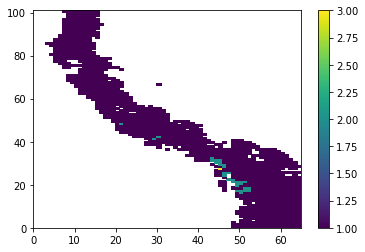

In [405]:
plt.pcolormesh(outmax_gt)
plt.colorbar()

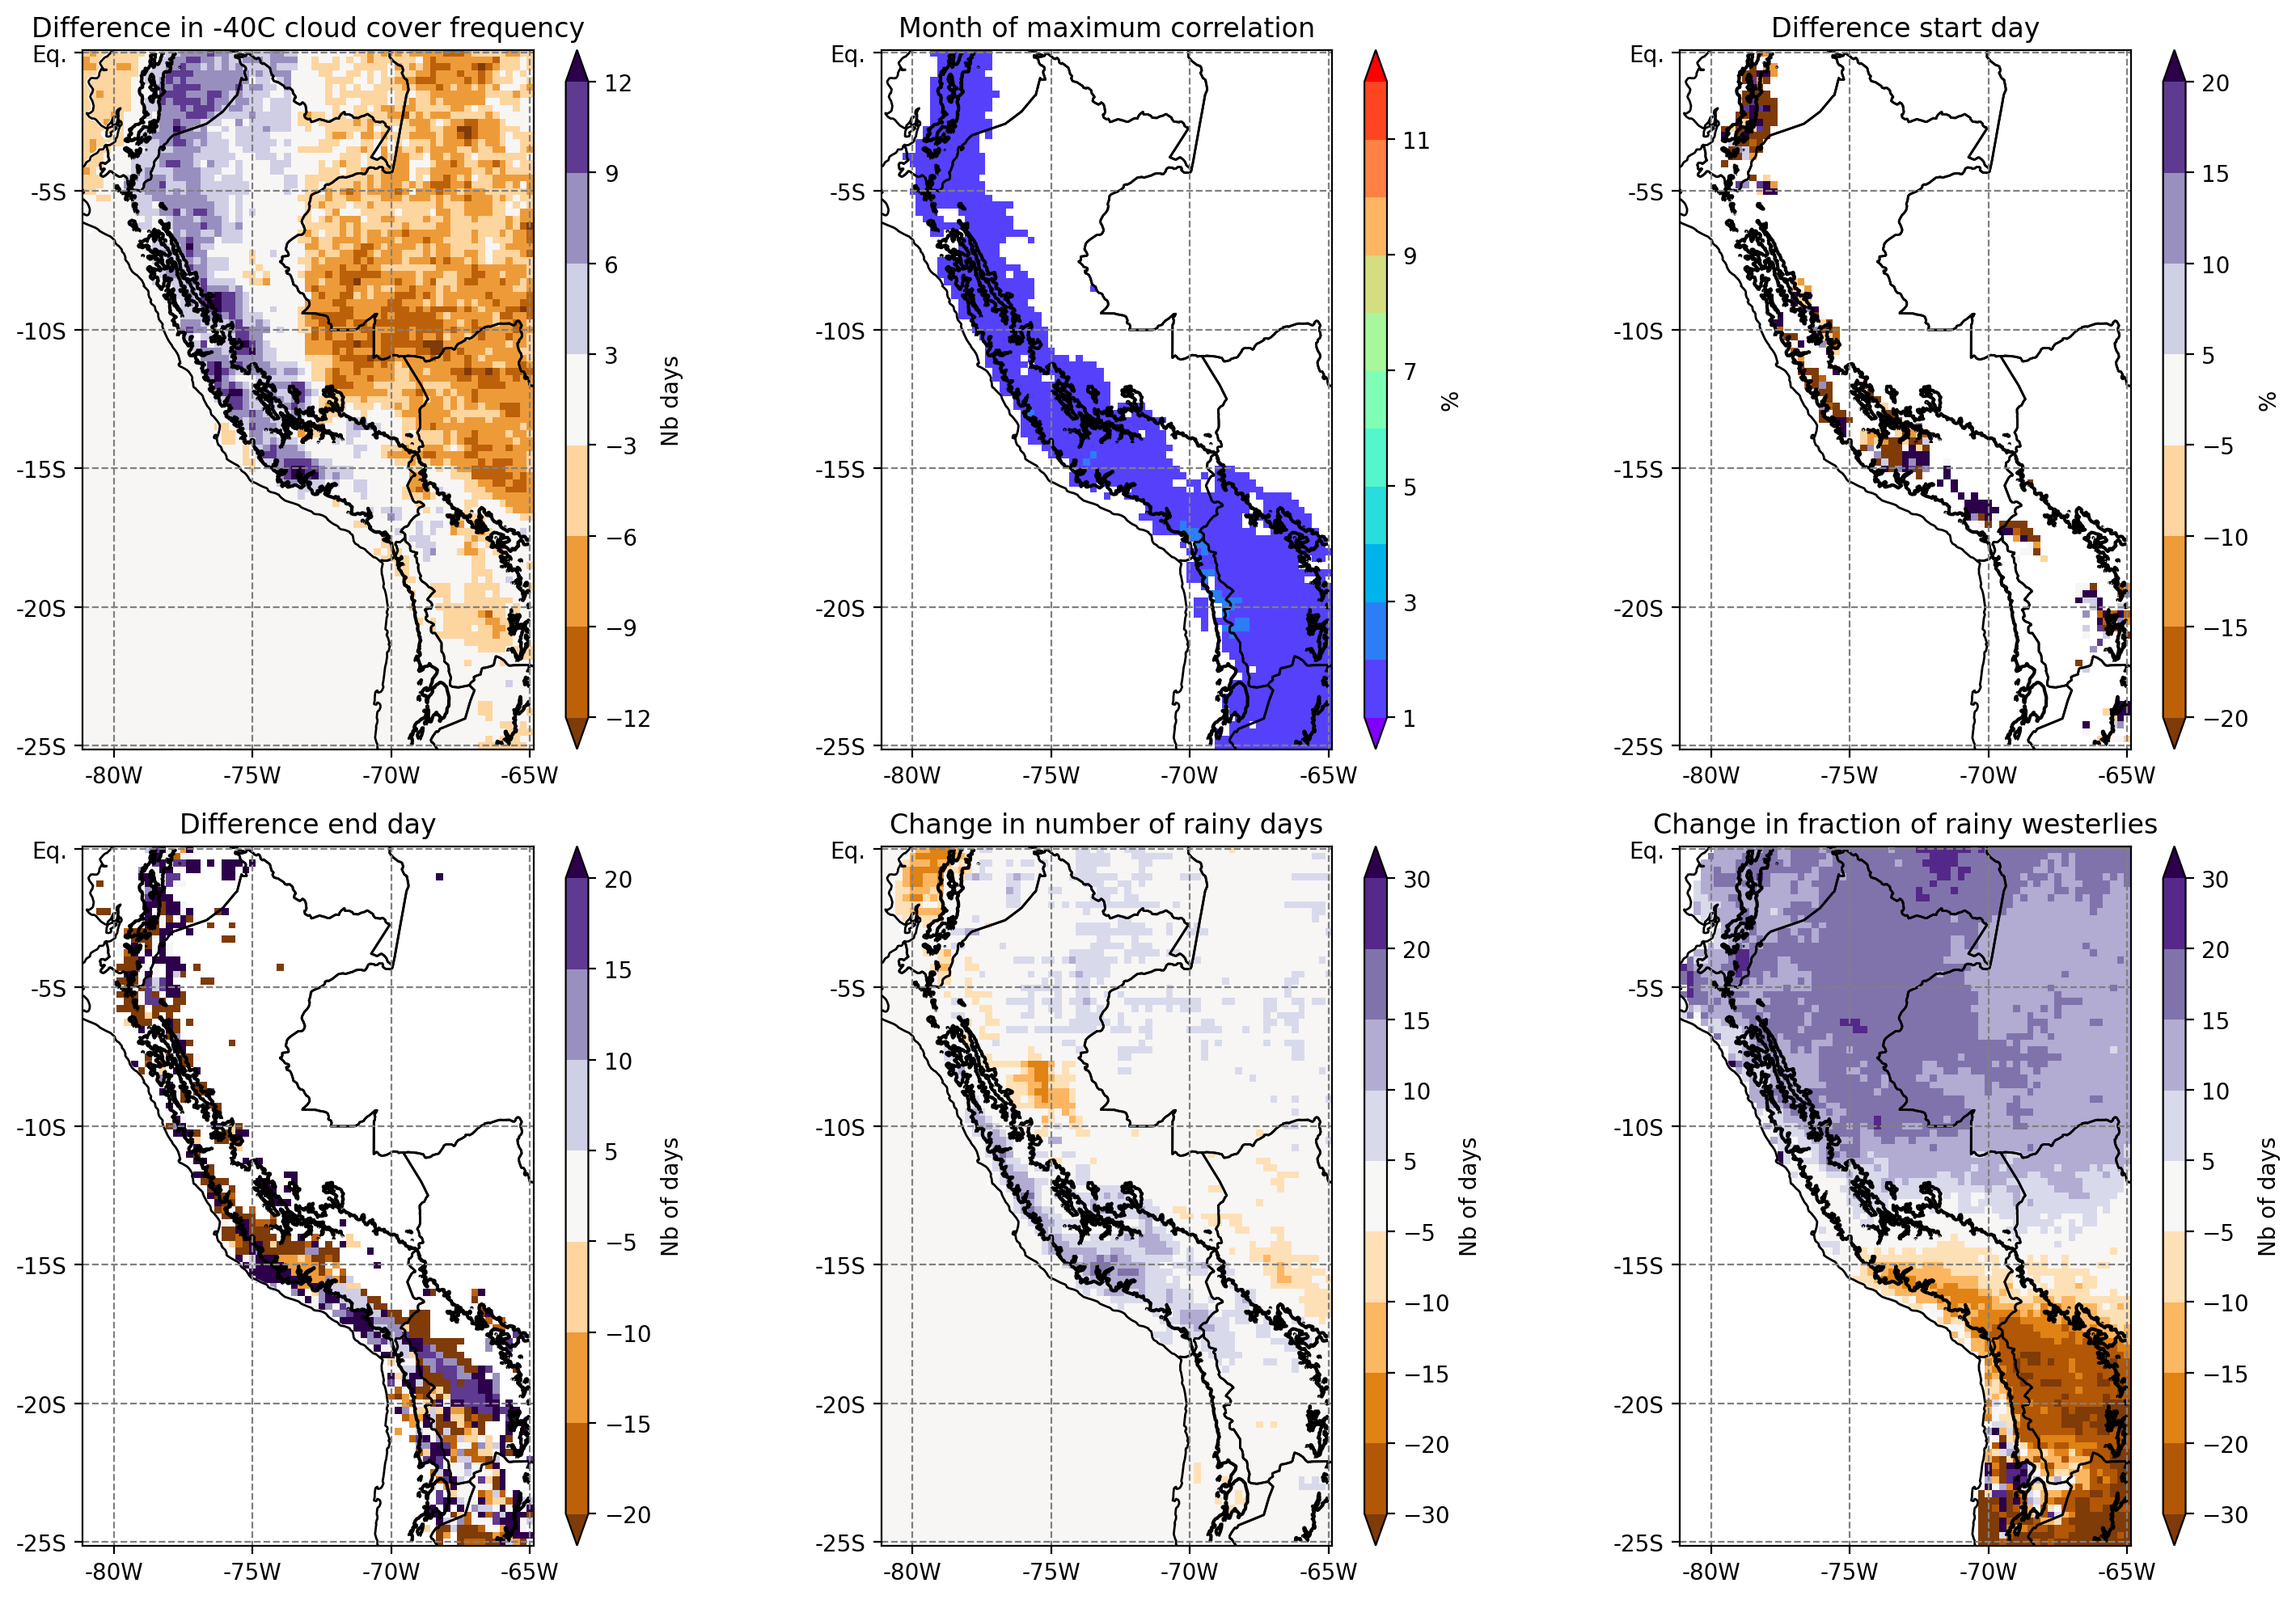

In [404]:
lakes = salem.read_shapefile(salem.get_demo_file('ne_50m_lakes.shp'),
                              cached=True)


f = plt.figure(figsize=(15,10), dpi=200)

box = [-85,-74,-10,-5]
map = corr_all.salem.get_map()
#.sel(longitude=slice(box[0],box[1]), latitude=slice(box[2], box[3]))
topo = topo#.sel(lon=slice(box[0],box[1]), lat=slice(box[2], box[3]))

# ax = f.add_subplot(231)
# #outarr_3.values[(topo_on_g<300)]=np.nan
# map.set_data(outarr_3)
# map.set_plot_params(levels=np.arange(182,335,6), cmap='jet', extend='both') #[182,213,244,274,305,335, 366]  # 182-July, 335- December
# map.set_contour(topo, interp='linear', levels=[0,3000], cmap='Greys')
# plt.plot(-77.5, -9.5, 'ro', markersize=5)
# map.visualize(cbar_title='Day of year', title='3-day correlation onset [July-November]')

# ax = f.add_subplot(232)
# endarr_5.values[(topo_on_g<300)]=np.nan # | (endarr_5<65)
# map.set_data(endarr_5)
# map.set_plot_params(levels=np.arange(60,152,6), cmap='jet_r', extend='both') # 60 March, 152 June
# map.set_contour(topo, interp='linear', levels=[0,3000], cmap='Greys')
# map.visualize(cbar_title='Day of year', title='5-day correlation retreat [March-May]')
# plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(231)
#endarr_5.values[(topo_on_g<300)]=np.nan # | (endarr_5<65)
season = (g_end-g_all)
map.set_data(season)
map.set_plot_params(levels=[-12, -9,-6, -3, 3,6,9,12], cmap='PuOr', extend='both')
map.set_contour(topo, interp='linear', levels=[0, 3000], cmap='Greys')
map.visualize(cbar_title='Nb days', title='Difference in -40C cloud cover frequency')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(232)
data = outmax_gt
# data.values[(corr_first_num.values<30)]=np.nan
# data.values[np.isnan(season)] = np.nan
#data[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data)
map.set_plot_params(levels=np.arange(1,13,1), cmap='rainbow', extend='both')
map.set_contour(topo, interp='linear', levels=[0, 3000], cmap='Greys')
map.visualize(cbar_title='%', title='Month of maximum correlation')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(233)
data = outarr_3e-outarr_3f
map.set_data(data)
map.set_plot_params(levels=[-20,-15,-10, -5, 5,10,15,20], cmap='PuOr', extend='both')
map.set_contour(topo, interp='linear', levels=[0, 3000], cmap='Greys')
map.visualize(cbar_title='%', title='Difference start day')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(234)
data = endarr_5e-endarr_5f
#data.values[corr_all_num.values<60]=np.nan
#endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data)
map.set_plot_params(levels=[-20,-15,-10, -5, 5,10,15,20], cmap='PuOr', extend='both')
map.set_contour(topo, interp='linear', levels=[0,3000], cmap='Greys')
map.visualize(cbar_title='Nb of days', title='Difference end day')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(235)

data = (ch_end-ch_all)#/ch_all*100
#data = g_end-g_all
#data.values[corr_all_num.values<60]=np.nan
#endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data)
map.set_plot_params(levels=[-30,-20,-15,-10, -5, 5,10,15,20,30], cmap='PuOr', extend='both')
map.set_contour(topo, interp='linear', levels=[0,3000], cmap='Greys')
map.visualize(cbar_title='Nb of days', title='Change in number of rainy days')
plt.plot(-77.5, -9.5, 'ro', markersize=5)


ax = f.add_subplot(236)

data = (ch_end_frac-ch_all_frac)/ch_all_frac*100
#data = g_end-g_all
#data.values[corr_all_num.values<60]=np.nan
#endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data)
map.set_plot_params(levels=[-30,-20,-15,-10, -5, 5,10,15,20,30], cmap='PuOr', extend='both')
map.set_contour(topo, interp='linear', levels=[0,3000], cmap='Greys')
map.visualize(cbar_title='Nb of days', title='Change in fraction of rainy westerlies')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

plt.tight_layout()